In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
from astropy.cosmology import WMAP9 as cosmo
from scipy.integrate import quad
#from astropy.cosmology import Planck15   # You can choose a different cosmology if needed
import astropy.units as u
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM
from numba import jit
from glob import glob
import pandas as pd
from scipy.stats import gaussian_kde
from tqdm import tqdm

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


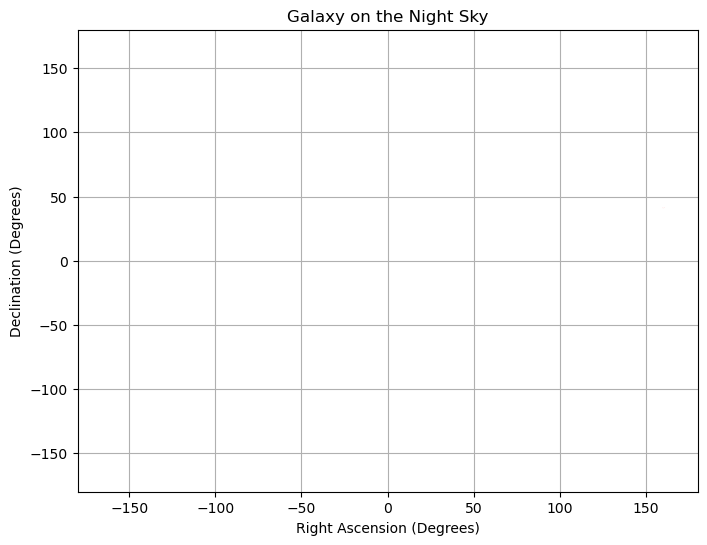

In [2]:


def plot_galaxy(ra, dec, angular_size_mas, orientation_deg):
    # Convert RA and Dec to degrees for plotting (assuming RA is given in hours)
    ra_deg = ra * 15  # 1 hour = 15 degrees
    dec_deg = dec
    
    # Convert angular size from mas to degrees
    angular_size_deg = angular_size_mas / 1000 / 3600
    
    # Set up figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plotting the galaxy as an ellipse
    galaxy_ellipse = Ellipse((ra_deg, dec_deg), width=angular_size_deg, height=angular_size_deg/2, angle=orientation_deg, edgecolor='red', facecolor='none')
    
    ax.add_patch(galaxy_ellipse)
    
    # Setting labels and title
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Galaxy on the Night Sky')
    plt.grid(True)
    
    # Set limits for better visibility, assuming we're focusing on a small area of the sky
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    
    plt.show()

# Example values for a galaxy
ra_example = 10.684  # Right Ascension in hours
dec_example = 41.269  # Declination in degrees
angular_size_mas = 13000 # Angular size in milliarcseconds

orientation_deg_example = 45  # Orientation in degrees

# Plot the galaxy
plot_galaxy(ra_example, dec_example, angular_size_mas, orientation_deg_example)


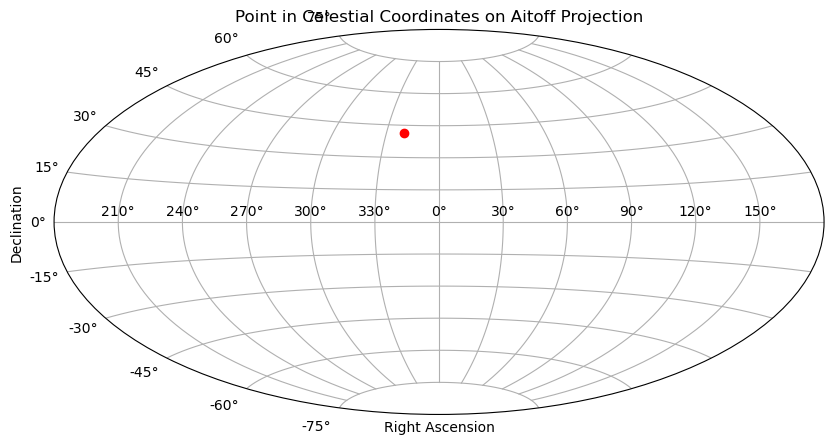

In [3]:
def plot_celestial_point_aitoff(ra_hours, dec_degrees):
    # Convert Right Ascension from hours to radians for the Aitoff projection
    # RA is adjusted by subtracting 12 hours to center the plot, then converted to radians
    ra_radians = np.radians((ra_hours - 12) * 15)
    
    # Convert Declination from degrees to radians
    dec_radians = np.radians(dec_degrees)
    
    # Set up the plot with Aitoff projection
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='aitoff')
    
    # Plot the point
    ax.plot(ra_radians, dec_radians, 'ro')  # 'ro' plots a red dot
    
    # Setting grid and labels
    ax.grid(True)
    plt.title('Point in Celestial Coordinates on Aitoff Projection')
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')
    ax.xaxis.label.set_fontsize(10)
    ax.yaxis.label.set_fontsize(10)
    
    # Adjust the tick labels for RA and Dec to be more readable
    ax.set_xticklabels(['210°', '240°', '270°', '300°', '330°', '0°', '30°', '60°', '90°', '120°', '150°'])
    #ax.set_yticklabels(['-60°', '-30°', '0°', '30°', '60°'])
    
    plt.show()

# Example values for RA and Dec
ra_example = 10.684  # RA in hours
dec_example = 41.269  # Dec in degrees

# Plot the point on the celestial map with an Aitoff projection
plot_celestial_point_aitoff(ra_example, dec_example)

In [4]:
cso_galaxies ={

  
    "J0000+4054": {"R.A.": "00:00:53.08", "Dec.": "+40:54:01.81", "z": 'nan', 'Ang_size': '124.0', 'lin_size': 'nan', 'Turnover_freq': '0.323', 'Turnover_flux_den': '2.06','class':'nan'},
    "J0003+4807": {"R.A.": "00:03:46.04", "Dec.": "+48:07:04.14", "z": 'nan', 'Ang_size': '16.2', 'lin_size': '0.139', 'Turnover_freq': '2.123', 'Turnover_flux_den': '0.348','class':'nan'},
    "J0029+3456": {"R.A.": "00:29:14.24", "Dec.": "+34:56:32.25", "z": '0.517' ,'Ang_size': '29.1', 'lin_size': '0.180', 'Turnover_freq': '0.8', 'Turnover_flux_den': '2.0','class':'2.1','major_axis_comb':'4.2'},
    "J0111+3906": {"R.A.": "01:11:37.32", "Dec.": "+39:06:28.10", "z": '0.66847', 'Ang_size': '8.0', 'lin_size': '0.056', 'Turnover_freq': '4.0', 'Turnover_flux_den': '1.33','class':'2.0','major_axis_comb':'4.0' },
    "J0119+3210": {"R.A.": "01:19:35.00", "Dec.": "+32:10:50.06", "z": '0.0602', 'Ang_size': '100.0', 'lin_size': '0.115', 'Turnover_freq': '0.4', 'Turnover_flux_den': '4.0','class':'2.2','major_axis_comb':'32.9'},
    "J0131+5545": {"R.A.": "01:31:13.82", "Dec.": "+55:45:12.98", "z": '0.003649', 'Ang_size': '23.0', 'lin_size': '0.016', 'Turnover_freq': '0.657', 'Turnover_flux_den': '0.31','class':'2.2'},
    "J0132+5620": {"R.A.": "01:32:20.45", "Dec.": "+56:20:40.37", "z": 'nan', 'Ang_size': '12.2', 'lin_size': '0.104', 'Turnover_freq': '3.42', 'Turnover_flux_den': '0.6','class':'nan'},
    "J0150+4017": {"R.A.": "01:50:19.61", "Dec.": "+40:17:30.02", "z": 'nan', 'Ang_size': '103.0', 'lin_size': '0.882', 'Turnover_freq': '0.4', 'Turnover_flux_den': '2.0','class':'nan'},
    "J0204+0903": {"R.A.": "02:04:34.76", "Dec.": "+09:03:49.26", "z": 'nan', 'Ang_size': '33.0', 'lin_size': '0.282', 'Turnover_freq': '1.3', 'Turnover_flux_den': '2.0','class':'nan'},
    "J0237+4342": {"R.A.": "02:37:01.21", "Dec.": "+43:42:04.18", "z": 'nan', 'Ang_size': '120.0', 'lin_size': 'nan', 'Turnover_freq': '0.3', 'Turnover_flux_den': '0.868','class':'nan'},
    "J0402+8241": {"R.A.": "04:02:12.68", "Dec.": "+82:41:35.13", "z": 'nan', 'Ang_size': '72.0', 'lin_size': '0.616', 'Turnover_freq': '0.4', 'Turnover_flux_den': '0.4','class':'nan'},
    "J0405+3803": {"R.A.": "04:05:49.26", "Dec.": "+38:03:32.24", "z": '0.05505', 'Ang_size': '42.0', 'lin_size': '0.044', 'Turnover_freq': '0.07', 'Turnover_flux_den': '5.5','class':'2.0'},
    "J0425-1612": {"R.A.": "04:25:53.57", "Dec.": "-16:12:40.23", "z": 'nan', 'Ang_size': '99.8', 'lin_size': '0.854', 'Turnover_freq': '0.363', 'Turnover_flux_den': '1.449','class':'nan'},
    "J0427+4133": {"R.A.": "04:27:46.05", "Dec.": "+41:33:01.10", "z": 'nan', 'Ang_size': '7.0', 'lin_size': '0.060', 'Turnover_freq': '3.3', 'Turnover_flux_den': '0.74','class':'nan'},
    "J0440+6157": {"R.A.": "04:40:46.90", "Dec.": "+61:57:58.57", "z": 'nan', 'Ang_size': '30.0', 'lin_size': '0.257', 'Turnover_freq': '1.7', 'Turnover_flux_den': '0.24','class':'nan'},
    "J0706+4647": {"R.A.": "07:06:48.07", "Dec.": "+46:47:56.45", "z": 'nan', 'Ang_size': '63.0', 'lin_size': '0.539', 'Turnover_freq': '0.777', 'Turnover_flux_den': '1.81','class':'nan'},
    "J0713+4349": {"R.A.": "07:13:38.16", "Dec.": "+43:49:17.21", "z": '0.518', 'Ang_size': '35.0', 'lin_size': '0.217', 'Turnover_freq': '1.9', 'Turnover_flux_den': '2.09','class':'2.0'},
    "J0735-1735": {"R.A.": "07:35:45.81", "Dec.": "-17:35:48.50", "z": 'nan', 'Ang_size': '28.8', 'lin_size': '0.246', 'Turnover_freq': '1.4', 'Turnover_flux_den': '3','class':'nan'},
    "J0741+2706": {"R.A.": "07:41:25.73", "Dec.": "+27:06:45.42", "z": '0.772139', 'Ang_size': '26.0', 'lin_size': '0.193', 'Turnover_freq': '1.0', 'Turnover_flux_den': '1.05','class':'2.0'},
    "J0754+5324": {"R.A.": "07:54:15.22", "Dec.": "+53:24:56.45", "z": 'nan', 'Ang_size': '26.0', 'lin_size': '0.223', 'Turnover_freq': '1.24', 'Turnover_flux_den': '0.634','class':'nan'},
    "J0825+3919": {"R.A.": "08:25:23.68", "Dec.": "+39:19:45.76", "z": '1.21', 'Ang_size': '70.7', 'lin_size': '0.591', 'Turnover_freq': '0.517', 'Turnover_flux_den': '1.77','class':'2.1'},
    "J0832+1832": {"R.A.": "08:32:16.04", "Dec.": "+18:32:12.12", "z": '0.154', 'Ang_size': '30.7', 'lin_size': '0.081', 'Turnover_freq': '1.5', 'Turnover_flux_den': '1.2','class':'1'},
    "J0855+5751": {"R.A.": "08:55:21.36", "Dec.": "+57:51:44.09", "z": '0.025998', 'Ang_size': '75.0', 'lin_size': '0.039', 'Turnover_freq': '0.3', 'Turnover_flux_den': '1.5','class':'2.1'},





    "J0906+4124": {"R.A.": "09:06:52.80", "Dec.": "+41:24:30.00", "z": '0.0273577', 'Ang_size': '11.1', 'lin_size': '0.006', 'Turnover_freq': '1.5', 'Turnover_flux_den': '0.06','class':'1'},
    "J0909+1928": {"R.A.": "09:09:37.44", "Dec.": "+19:28:08.30", "z": '0.027843', 'Ang_size': '14.7', 'lin_size': '0.008', 'Turnover_freq': '6.0', 'Turnover_flux_den': '0.12','class':'1'},
    "J0943+1702": {"R.A.": "09:43:17.23", "Dec.": "+17:02:18.97", "z": '1.601115', 'Ang_size': '20.4', 'lin_size': '0.175', 'Turnover_freq': '4.0', 'Turnover_flux_den': '0.4','class':'2.0'},
    "J1011+4204": {"R.A.": "10:11:54.18", "Dec.": "+42:04:33.38", "z": 'nan', 'Ang_size': '115.0', 'lin_size': '0.984', 'Turnover_freq': '0.424', 'Turnover_flux_den': '1.16','class':'nan'},
    "J1025+1022": {"R.A.": "10:25:44.20", "Dec.": "+10:22:30.00", "z": '0.045805', 'Ang_size': '19.8', 'lin_size': '0.018', 'Turnover_freq': '1.0', 'Turnover_flux_den': '0.09','class':'1'},
    "J1035+5628": {"R.A.": "10:35:07.04", "Dec.": "+56:28:46.79", "z": '0.46', 'Ang_size': '38.0', 'lin_size': '0.221', 'Turnover_freq': '1.3', 'Turnover_flux_den': '1.87','class':'2.0'},
    "J1042+2949": {"R.A.": "10:42:36.51", "Dec.": "+29:49:45.15", "z": 'nan', 'Ang_size': '45.0', 'lin_size': '0.385', 'Turnover_freq': '0.7', 'Turnover_flux_den': '1','class':'nan'},
    "J1111+1955": {"R.A.": "11:11:20.07", "Dec.": "+19:55:36.01", "z": '0.299', 'Ang_size': '15.5', 'lin_size': '0.068', 'Turnover_freq': '1.305', 'Turnover_flux_den': '1.1','class':'2.0'},
    "J1120+1420": {"R.A.": "11:20:27.81", "Dec.": "+14:20:54.97", "z": '0.362' ,'Ang_size': '101.0', 'lin_size': '0.507', 'Turnover_freq': '0.5', 'Turnover_flux_den': '3.89','class':'2.0'},
    "J1135+4258": {"R.A.": "11:35:55.99", "Dec.": "+42:58:44.65", "z": 'nan', 'Ang_size': '29.0', 'lin_size': '0.248', 'Turnover_freq': '1.0', 'Turnover_flux_den': '1.45','class':'nan'},
    "J1148+5924": {"R.A.": "11:48:50.36", "Dec.": "+59:24:56.36", "z": '0.01075', 'Ang_size': '54.8', 'lin_size': '0.012', 'Turnover_freq': '6.149', 'Turnover_flux_den': '0.573','class':'1'},
    "J1158+2450": {"R.A.": "11:58:25.79", "Dec.": "+24:50:18.00", "z": '0.203', 'Ang_size': '46.0', 'lin_size': '0.152', 'Turnover_freq': '2.0', 'Turnover_flux_den': '1.25','class':'2.2'},
    "J1159+5820": {"R.A.": "11:59:48.77", "Dec.": "+58:20:20.31", "z": '1.27997', 'Ang_size': '70.2', 'lin_size': '0.591', 'Turnover_freq': '0.6', 'Turnover_flux_den': '1.9','class':'2.0'},
    "J1204+5202": {"R.A.": "12:04:18.61", "Dec.": "+52:02:17.62", "z": 'nan', 'Ang_size': '54.0', 'lin_size': '0.462', 'Turnover_freq': '0.7', 'Turnover_flux_den': '1.4','class':'nan'},
    "J1205+2031": {"R.A.": "12:05:51.50", "Dec.": "+20:31:19.00", "z": '0.02378857', 'Ang_size': '22.0', 'lin_size': '0.010', 'Turnover_freq': '1', 'Turnover_flux_den': '0.14','class':'2.1'},
    "J1220+2916": {"R.A.": "12:20:06.82", "Dec.": "+29:16:50.72", "z": '0.002', 'Ang_size': '46.8', 'lin_size': '0.002', 'Turnover_freq': '0.074', 'Turnover_flux_den': '0.65','class':'1'},
    "J1227+3635": {"R.A.": "12:27:58.72", "Dec.": "+36:35:11.82", "z": '1.975', 'Ang_size': '58.8', 'lin_size': '0.499', 'Turnover_freq': '1.2', 'Turnover_flux_den': '2.14','class':'2.0'},
    "J1234+4753": {"R.A.": "12:34:13.33", "Dec.": "+47:53:51.24", "z": '0.373082', 'Ang_size': '27.4', 'lin_size': '0.140', 'Turnover_freq': '1.4', 'Turnover_flux_den': '0.36','class':'2.1'},
    "J1244+4048": {"R.A.": "12:44:49.19", "Dec.": "+40:48:06.15", "z": '0.813586', 'Ang_size': '70.0', 'lin_size': '0.529', 'Turnover_freq': '0.405', 'Turnover_flux_den': '2.03','class':'2.2'},
    "J1247+6723": {"R.A.": "12:47:33.33", "Dec.": "+67:23:16.45", "z": '0.107219', 'Ang_size': '5.0', 'lin_size': '0.010', 'Turnover_freq': '1.16', 'Turnover_flux_den': '0.36','class':'2.0'},
    "J1254+1856": {"R.A.": "12:54:33.27", "Dec.": "+18:56:01.93", "z": '0.1145', 'Ang_size': '4.14', 'lin_size': '0.008', 'Turnover_freq': '6.0', 'Turnover_flux_den': '0.13','class':'1'},
    "J1311+1658": {"R.A.": "13:11:23.82", "Dec.": "+16:58:44.22", "z": '0.081408', 'Ang_size': '27.0', 'lin_size': '0.041', 'Turnover_freq': '0.447', 'Turnover_flux_den': '0.824','class':'1'},
    "J1313+5458": {"R.A.": "13:13:37.85", "Dec.": "+54:58:23.91", "z": '0.613', 'Ang_size': '57.0', 'lin_size': '0.384', 'Turnover_freq': '0.555', 'Turnover_flux_den': '1.65','class':'2.2'},
    "J1326+3154": {"R.A.": "13:26:16.51", "Dec.": "+31:54:09.52", "z": '0.36801', 'Ang_size': '68.0', 'lin_size': '0.345', 'Turnover_freq': '0.5', 'Turnover_flux_den': '7.03','class':'2.2'},
    "J1335+5844": {"R.A.": "13:35:25.93", "Dec.": "+58:44:00.29", "z": 'nan', 'Ang_size': '12.9', 'lin_size': '0.110', 'Turnover_freq': '4.9', 'Turnover_flux_den': '0.9','class':'nan'},
    "J1347+1217": {"R.A.": "13:47:33.36", "Dec.": "+12:17:24.24", "z": '0.121', 'Ang_size': '100.0', 'lin_size': '0.215', 'Turnover_freq': '0.4', 'Turnover_flux_den': '8.86','class':'2.2'},
    "J1400+6210": {"R.A.": "14:00:28.65", "Dec.": "+62:10:38.59", "z": '0.431', 'Ang_size': '67.6', 'lin_size': '0.378', 'Turnover_freq': '0.5', 'Turnover_flux_den': '6.56','class':'2.2'},
    "J1407+2827": {"R.A.": "14:07:00.40", "Dec.": "+28:27:14.69", "z": '0.077', 'Ang_size': '11.0', 'lin_size': '0.016', 'Turnover_freq': '4.9', 'Turnover_flux_den': '3.0','class':'2.1'},
    "J1413+1509": {"R.A.": "14:13:41.66", "Dec.": "+15:09:39.51", "z": 'nan', 'Ang_size': '15.0', 'lin_size': '0.128', 'Turnover_freq': '2.5', 'Turnover_flux_den': '0.47','class':'nan'},
    "J1414+4554": {"R.A.": "14:14:14.85", "Dec.": "+45:54:48.73", "z": '0.186', 'Ang_size': '30.5', 'lin_size': '0.094', 'Turnover_freq': '0.693', 'Turnover_flux_den': '0.396','class':'2.1'},
    "J1416+3444": {"R.A.": "14:16:04.18", "Dec.": "+34:44:24", "z": 'nan', 'Ang_size': '81.0', 'lin_size': '0.693', 'Turnover_freq': '0.7', 'Turnover_flux_den': '2.1','class':'nan'},

    "J1434+4236": {"R.A.": "14:34:27.86", "Dec.": "+42:36:20.06", "z": '0.452', 'Ang_size': '68.3', 'lin_size': '0.393', 'Turnover_freq': '0.074', 'Turnover_flux_den': '1.67','class':'2.2'},
    "J1440+6108": {"R.A.": "14:40:17.87", "Dec.": "+61:08:42.88", "z": '0.445365', 'Ang_size': '30.0', 'lin_size': '0.171', 'Turnover_freq': '0.4', 'Turnover_flux_den': '0.48','class':'2.1'},
    "J1443+4044": {"R.A.": "14:42:59.32", "Dec.": "+40:44:28.94", "z": 'nan', 'Ang_size': '123.4', 'lin_size': 'nan', 'Turnover_freq': '0.292', 'Turnover_flux_den': '1.55','class':'nan'},
    "J1508+3423": {"R.A.": "15:08:05.70", "Dec.": "+34:23:23.00", "z": '0.045565', 'Ang_size': '280.0', 'lin_size': '0.247', 'Turnover_freq': '0.23', 'Turnover_flux_den': '0.25','class':'2.1'},
    "J1511+0518": {"R.A.": "15:11:41.27", "Dec.": "+05:18:09.26", "z": '0.084', 'Ang_size': '10.6', 'lin_size': '0.017', 'Turnover_freq': '0.4', 'Turnover_flux_den': '0.48','class':'2.0'},
    "J1559+5924": {"R.A.": "15:59:01.70", "Dec.": "+59:24:21.84", "z": '0.0602', 'Ang_size': '11.0', 'lin_size': '0.013', 'Turnover_freq': '0.15', 'Turnover_flux_den': '0.23','class':'1'},
    "J1602+5243": {"R.A.": "16:02:46.38", "Dec.": "+52:43:58.40", "z": '0.105689', 'Ang_size': '250.0', 'lin_size': '0.478', 'Turnover_freq': '0.15', 'Turnover_flux_den': '1.48','class':'1'},
    "J1609+2641": {"R.A.": "16:09:13.32", "Dec.": "+26:41:29.04", "z": '0.473', 'Ang_size': '61.3', 'lin_size': '0.362', 'Turnover_freq': '1.1', 'Turnover_flux_den': '5.44','class':'2.1'},
    "J1645+2536": {"R.A.": "16:44:59.07", "Dec.": "+25:36:30.64", "z": '0.588', 'Ang_size': '39.0', 'lin_size': '0.258', 'Turnover_freq': '1.0', 'Turnover_flux_den': '1.1','class':'2.1'},
    "J1723-6500": {"R.A.": "17:23:41.03", "Dec.": "-65:00:36.61", "z": '0.01443', 'Ang_size': '7.0', 'lin_size': '0.002', 'Turnover_freq': '2.7', 'Turnover_flux_den': '4.48','class':'2.1'},
    "J1734+0926": {"R.A.": "17:34:58.38", "Dec.": "+09:26:58.26", "z": '0.735', 'Ang_size': '12.8', 'lin_size': '0.093', 'Turnover_freq': '2.3', 'Turnover_flux_den': '1.22','class':'2.0'},
    "J1735+5049": {"R.A.": "17:35:49.01", "Dec.": "+50:49:11.57", "z": '0.835', 'Ang_size': '8.0', 'lin_size': '0.061', 'Turnover_freq': '6.4', 'Turnover_flux_den': '0.972','class':'2.0'},
    "J1816+3457": {"R.A.": "18:16:23.90", "Dec.": "+34:57:45.75", "z": '0.245', 'Ang_size': '45.5', 'lin_size': '0.174', 'Turnover_freq': '0.44', 'Turnover_flux_den': '0.983','class':'2.1'},
    "J1826+1831": {"R.A.": "18:26:17.71", "Dec.": "+18:31:52.89", "z": 'nan', 'Ang_size': '74.0', 'lin_size': '0.633', 'Turnover_freq': '0.308', 'Turnover_flux_den': '1.08','class':'nan'},
    "J1826+2708": {"R.A.": "18:26:32.11", "Dec.": "+27:08:07.95", "z": 'nan', 'Ang_size': '41.0', 'lin_size': '0.351', 'Turnover_freq': '1.0', 'Turnover_flux_den': '0.34','class':'nan'},
    "J1915+6548": {"R.A.": "19:15:23.82", "Dec.": "+65:48:46.39", "z": '0.486', 'Ang_size': '36.0', 'lin_size': '0.216', 'Turnover_freq': '0.5', 'Turnover_flux_den': '0.83','class':'2.1'},
    "J1928+6815": {"R.A.": "19:28:20.55", "Dec.": "+68:14:59.27", "z": 'nan', 'Ang_size': '128.1', 'lin_size': 'nan', 'Turnover_freq': '0.074', 'Turnover_flux_den': '1.04','class':'nan'},
    "J1939-6342": {"R.A.": "19:39:25.02", "Dec.": "-63:42:45.62", "z": '0.183', 'Ang_size': '42.6', 'lin_size': '0.130', 'Turnover_freq': '1.4', 'Turnover_flux_den': '15.0','class':'2.0'},
    "J1944+5448": {"R.A.": "19:44:31.51", "Dec.": "+54:48:07.06", "z": '0.263', 'Ang_size': '48.8', 'lin_size': '0.196', 'Turnover_freq': '0.778', 'Turnover_flux_den': '1.77','class':'2.0'},
    "J1945+7055": {"R.A.": "19:45:53.52", "Dec.": "+70:55:48.73", "z": '0.101', 'Ang_size': '40.6', 'lin_size': '0.075', 'Turnover_freq': '1.8', 'Turnover_flux_den': '0.929','class':'2.2'},
 
    "J2022+6136": {"R.A.": "20:22:06.68", "Dec.": "+61:36:58.80", "z": '0.2266', 'Ang_size': '29.0', 'lin_size': '0.104', 'Turnover_freq': '4.086', 'Turnover_flux_den': '2.64','class':'2.1'},
    "J2203+1007": {"R.A.": "22:03:30.95", "Dec.": "+10:07:42.59", "z": '1.005', 'Ang_size': '11.0', 'lin_size': '0.089', 'Turnover_freq': '4.427', 'Turnover_flux_den': '0.306','class':'2.0'},
    "J2327+0846": {"R.A.": "23:27:56.70", "Dec.": "+08:46:44.30", "z": '0.02892', 'Ang_size': '1300.0', 'lin_size': '0.744', 'Turnover_freq': '0.09', 'Turnover_flux_den': '1.0','class':'1'},
    "J2347-1856": {"R.A.": "23:47:08.63", "Dec.": "-18:56:18.86", "z": 'nan', 'Ang_size': '33.4', 'lin_size': '0.186', 'Turnover_freq': '1.8', 'Turnover_flux_den': '0.66','class':'nan'},
    "J2355+4950": {"R.A.": "23:55:09.46", "Dec.": "+49:50:08.34", "z": '0.23831', 'Ang_size': '90', 'lin_size': '0.337', 'Turnover_freq': '0.7', 'Turnover_flux_den': '2.93','class':'2.2'},
       
}
print(len(cso_galaxies.keys()))
def parse_coordinates_RA(coord_str):
    if ':' in coord_str:
        # Split the string into hours, minutes, and seconds
        hours, minutes, seconds = map(float, coord_str.split(':'))
        
        # Convert to degrees
        degrees = ((hours  + minutes / 60 + seconds / 3600))*15
        
        return degrees
    else:
        return float(coord_str)
    
def parse_coordinates_deg(coord_str):
    if ':' in coord_str:
        # Split the string into hours, minutes, and seconds
        deg, ass, mas = map(float, coord_str.split(':'))
      
        # Convert to degrees
        degrees = deg + ass / 60 + mas / 3600
        #degrees = hours * 15 + minutes / 4 + seconds / 240
        
        return degrees
    else:
        return float(coord_str)
def convert_value(value):
    if value == 'nan':  # Convert 'nan' strings to np.nan
        return np.nan
    try:
        return float(value)  # Convert strings to floats
    except ValueError:
        return value  # Return the value unchanged if it's not a float or 'nan'

# Iterate over the items in the dictionary and convert
for galaxy, properties in cso_galaxies.items():
    for key in properties:
        properties[key] = convert_value(properties[key])


#parse_coordinates_RA(cso_galaxies['J1035+5628']['R.A.'])  # Expected output: 305.5278333333333
#parse_coordinates_deg(cso_galaxies['J1035+5628']['Dec.'])
print(cso_galaxies['J1035+5628']) 


79
{'R.A.': '10:35:07.04', 'Dec.': '+56:28:46.79', 'z': 0.46, 'Ang_size': 38.0, 'lin_size': 0.221, 'Turnover_freq': 1.3, 'Turnover_flux_den': 1.87, 'class': 2.0}


c:\Users\henri\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


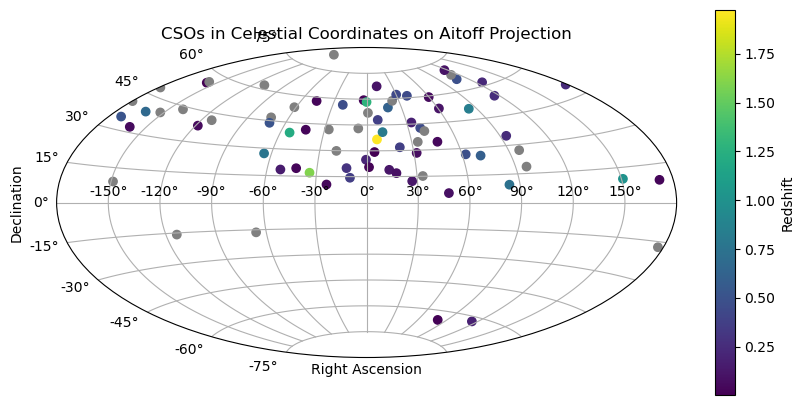

In [5]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='aitoff')
norm = plt.Normalize(-3.14, 3.14)
redshift_list = []
ra_radians=[]
dec_radians=[]
labels = []
for keys in cso_galaxies:
    redshift_list.append(np.nan if (cso_galaxies[keys]['z']=="nan") else float(cso_galaxies[keys]['z']))
    ra_radians.append(np.radians(parse_coordinates_RA(cso_galaxies[keys]['R.A.'])-180))
    dec_radians.append(np.radians(parse_coordinates_deg(cso_galaxies[keys]['Dec.'])))
    labels.append(keys)


valid_redshifts = [z for z in redshift_list if not np.isnan(z)]

min_z = min(valid_redshifts)
max_z = max(valid_redshifts)
norm = plt.Normalize(min_z, max_z)

cmap = plt.get_cmap('viridis')
colors = [cmap(norm(z)) if not np.isnan(z) else "grey" for z in redshift_list]

# Plot the point
ax.scatter(ra_radians,dec_radians, c=colors, label=labels)

plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Redshift')
# Setting grid and labels
ax.grid(True)
plt.title('CSOs in Celestial Coordinates on Aitoff Projection')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.xaxis.label.set_fontsize(10)
ax.yaxis.label.set_fontsize(10)
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize='small')

# Adjust the tick labels for RA and Dec to be more readable
#ax.set_xticklabels(['210°', '240°', '270°', '300°', '330°', '0°', '30°', '60°', '90°', '120°', '150°'])
#ax.set_yticklabels(['-60°', '-30°', '0°', '30°', '60°'])
plt.savefig('C:/Users/henri/OneDrive/Documents/NTNU/Semester 10/Masteroppgave/Plots/BF_CSOs_Aitoff.png')
plt.show()

In [ ]:

from astropy.coordinates import SkyCoord
# Function to read CSV files and extract data
def read_icecube_data(csv_files):
    frames = []
    for file in csv_files:
        # Attempt to automatically detect the delimiter

        df = pd.read_csv(file, sep='\s+',comment = '#', header=None, names=['MJD[days]' , 'log10(E/GeV)' ,'AngErr[deg]',       'RA[deg]' ,     'Dec[deg]' , 'Azimuth[deg]',  'Zenith[deg]'], )
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

# Assuming the CSV files are named in a recognizable pattern and stored in a directory named "events"
csv_files = glob('C:/Users/henri/OneDrive/Documents/NTNU/Semester 10/Masteroppgave/icecube_10year_ps/events/*.csv')

# Read the data
data = read_icecube_data(csv_files)
print(data)
# Extract RA and Dec



In [ ]:
ra = data['RA[deg]']
dec = data['Dec[deg]']

# Convert to astropy SkyCoord object
coords = SkyCoord(ra=ra.values*u.degree, dec=dec.values*u.degree, frame='icrs')

# Plotting
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(projection="aitoff")
ax.scatter(coords.ra.wrap_at('180d').radian, coords.dec.radian, alpha=0.5, s=0.001)

plt.title('ICECube Observations Sky Map')
plt.grid(True)
plt.show()

In [ ]:
def zoom_sky_map(data, target_coord, radius_deg):
    """
    Plots points within a certain radius of a target coordinate, focusing on the zoomed area.
    
    Parameters:
    - data: DataFrame containing the sky map data.
    - target_coord: A SkyCoord object for the target coordinate.
    - radius_deg: The radius around the target coordinate, in degrees.
    """
    # Convert data to SkyCoord object
    data_coords = SkyCoord(ra=data['RA[deg]'].values*u.degree, dec=data['Dec[deg]'].values*u.degree, frame='icrs')
    
    # Calculate the separation between the target coordinate and each point
    sep = target_coord.separation(data_coords)
    
    # Filter points within the specified radius
    within_radius = sep < radius_deg * u.deg
    
    # Extracting the RA and Dec for points within the radius
    ra_within = data_coords.ra[within_radius].degree
    dec_within = data_coords.dec[within_radius].degree
    
    # Plotting
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Scatter plot of the points within the radius
    ax.scatter(ra_within, dec_within, color='red', s=10)  # Points within radius
    ax.scatter(target_coord.ra.degree, target_coord.dec.degree, color='red', marker='x', label='Target Coordinate')
    # Setting plot limits to focus on the zoomed area
    ax.set_xlim(target_coord.ra.degree - radius_deg, target_coord.ra.degree + radius_deg)
    ax.set_ylim(target_coord.dec.degree - radius_deg, target_coord.dec.degree + radius_deg)
    
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_ylabel('Declination (degrees)')
    ax.set_title(f'Zoomed area around RA={target_coord.ra.degree}, Dec={target_coord.dec.degree}')
    plt.grid(True)
    plt.show()


    
def heatmap_sky_map(data, target_coord, radius_deg, ax):
    # Ensure that AngErr values are positive and non-zero to avoid division by zero
    valid_data_mask = (data['AngErr[deg]'] > 0) & np.isfinite(data['RA[deg]']) & np.isfinite(data['Dec[deg]'])
    valid_data = data[valid_data_mask]
    
    # Filter data around the target_coord within the radius
    coords = SkyCoord(ra=valid_data['RA[deg]'].values*u.degree, dec=valid_data['Dec[deg]'].values*u.degree, frame='icrs')
    sep = target_coord.separation(coords)
    within_radius = sep < radius_deg * u.deg
    
    # If no points, return without plotting
    if not np.any(within_radius):
        
        ra_grid = np.linspace(target_coord.ra.degree - radius_deg, target_coord.ra.degree + radius_deg, 100)
        dec_grid = np.linspace(target_coord.dec.degree - radius_deg, target_coord.dec.degree + radius_deg, 100)
        ra_grid, dec_grid = np.meshgrid(ra_grid, dec_grid)
        kde_values = np.zeros_like(ra_grid)
        # Plotting the heatmap
        cax = ax.imshow(kde_values, extent=(ra_grid.min(), ra_grid.max(), dec_grid.min(), dec_grid.max()), origin='lower', aspect='auto', cmap='viridis', interpolation='none')
        fig.colorbar(cax, ax=ax, label='Probability Density')
        
    
    # If only one point, create a Gaussian centered at that point
    elif np.sum(within_radius) == 1:
        single_point = valid_data[within_radius]
        ra_within = single_point['RA[deg]'].values[0]
        dec_within = single_point['Dec[deg]'].values[0]
        ang_err_within = single_point['AngErr[deg]'].values[0]
        
        # Create a meshgrid around the target coordinate
        ra_grid = np.linspace(target_coord.ra.degree - radius_deg, target_coord.ra.degree + radius_deg, 100)
        dec_grid = np.linspace(target_coord.dec.degree - radius_deg, target_coord.dec.degree + radius_deg, 100)
        ra_grid, dec_grid = np.meshgrid(ra_grid, dec_grid)
        
        # Calculate the Gaussian distribution
        variance = (ang_err_within)**2
        gaussian = np.exp(-((ra_grid - ra_within)**2 + (dec_grid - dec_within)**2) / (2 * variance))
        gaussian /= (2 * np.pi * variance)  # Normalize
        
        # Plot the Gaussian
        cax = ax.imshow(gaussian, extent=(ra_grid.min(), ra_grid.max(), dec_grid.min(), dec_grid.max()), origin='lower', aspect='auto', cmap='viridis')
        fig.colorbar(cax, ax=ax, label='Probability Density')
        
    else:
        # Regular KDE for multiple points
        ra_within = valid_data['RA[deg]'][within_radius].values
        dec_within = valid_data['Dec[deg]'][within_radius].values
        ang_err_within = valid_data['AngErr[deg]'][within_radius].values
        Energies = valid_data['log10(E/GeV)'][within_radius].values
        N_t = len(ra_within)

        weights = 1 / ang_err_within**2 
        print(weights) # Use square of AngErr as weights for the KDE
        kde = gaussian_kde([ra_within, dec_within], weights=weights)
        
        # Create a grid to evaluate the KDE on
        ra_grid = np.linspace(target_coord.ra.degree - radius_deg, target_coord.ra.degree + radius_deg, 100)
        dec_grid = np.linspace(target_coord.dec.degree - radius_deg, target_coord.dec.degree + radius_deg, 100)
        ra_grid, dec_grid = np.meshgrid(ra_grid, dec_grid)
        kde_values = kde([ra_grid.ravel(), dec_grid.ravel()]).reshape(ra_grid.shape)
        
        # Plotting the heatmap
        cax = ax.imshow(kde_values, extent=(ra_grid.min(), ra_grid.max(), dec_grid.min(), dec_grid.max()), origin='lower', aspect='auto', cmap='viridis')
        fig.colorbar(cax, ax=ax, label='Probability Density')
    
    # Set limits to focus on the zoomed area
    ax.scatter(target_coord.ra.degree, target_coord.dec.degree, color='red', marker='x', label='Target Coordinate')
    ax.set_xlim(target_coord.ra.degree - radius_deg, target_coord.ra.degree + radius_deg)
    ax.set_ylim(target_coord.dec.degree - radius_deg, target_coord.dec.degree + radius_deg)
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_ylabel('Declination (degrees)')
    ax.set_title('Probability Heatmap')
    plt.grid(True)
    plt.show()


# Assuming the CSV files are located in a directory named "events"


# Read the data
object_name = "J1735+5049"  # For example
object_info = cso_galaxies[object_name]
zoom_radius = 30  # degrees

# Define your target coordinate (example: RA=203.024, Dec=16.760) and zoom radius in degrees
target_coord = SkyCoord(ra=object_info["R.A."], dec=object_info["Dec."], unit=(u.hourangle, u.deg))
target_coord = SkyCoord(ra=40.75, dec=0 , unit=(u.deg, u.deg))
zoom_sky_map(data, target_coord, zoom_radius)

fig, ax = plt.subplots(figsize=(8, 6))
heatmap_sky_map(data, target_coord, zoom_radius, ax)

{'R.A.': '17:35:49.01', 'Dec.': '+50:49:11.57', 'z': 0.835, 'Ang_size': 8.0, 'lin_size': 0.061, 'Turnover_freq': 6.4, 'Turnover_flux_den': 0.972, 'class': 2.0}


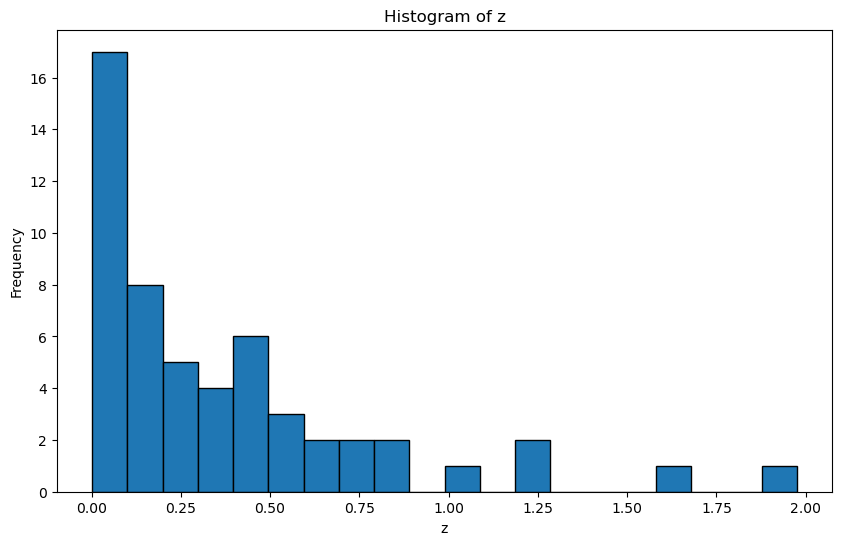

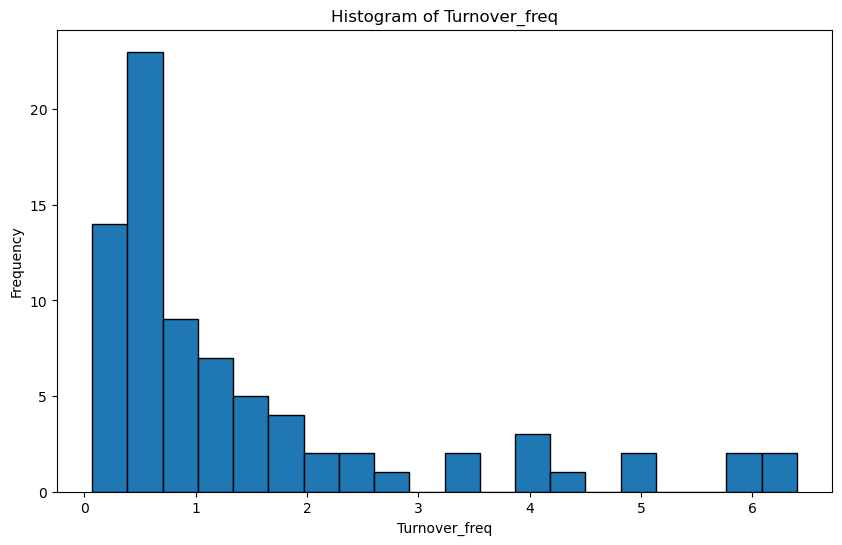

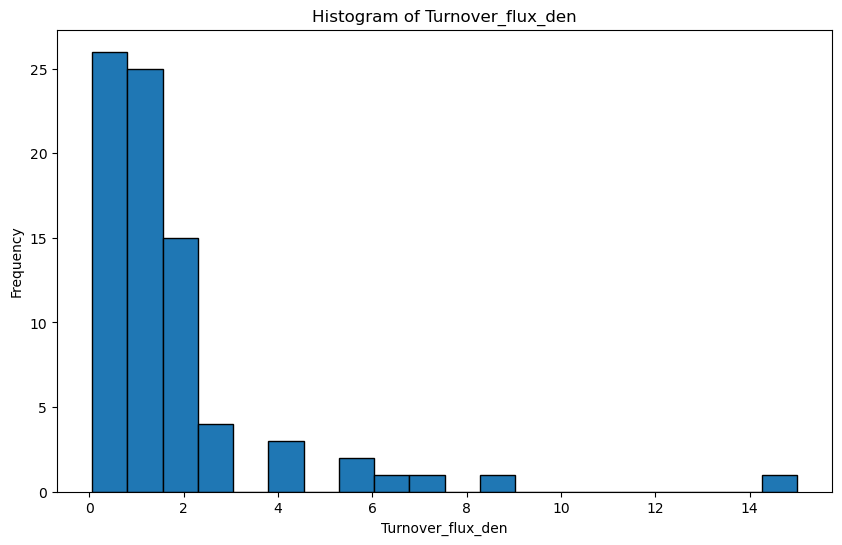

79 79


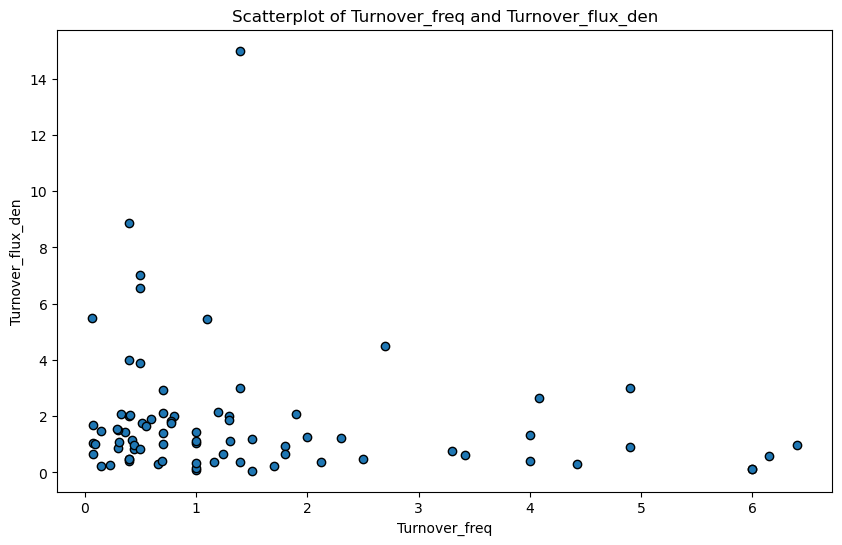

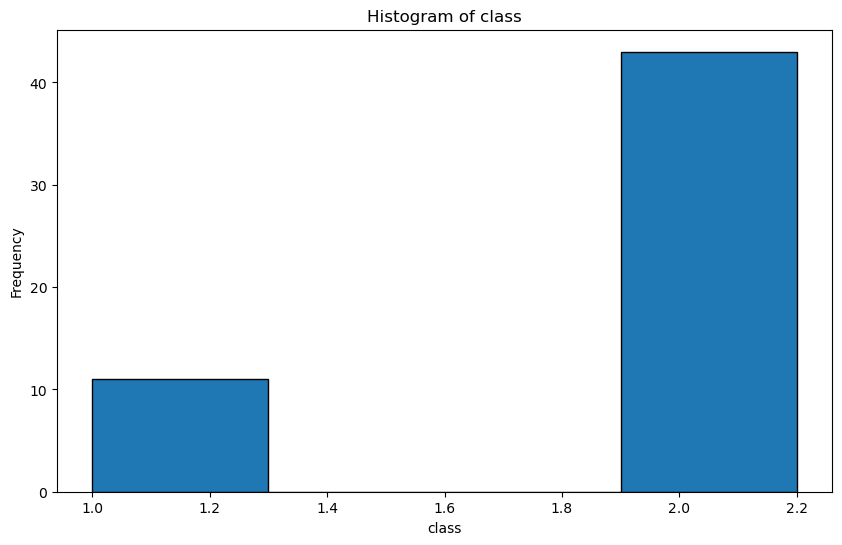

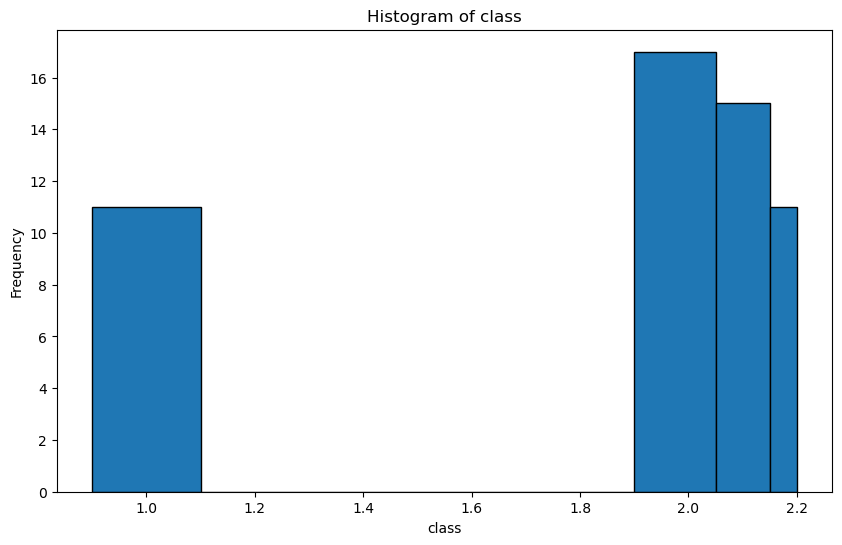

In [6]:
#### Histogram part

def plot_histogram_from_dict(data_dict, parameter, bins=10):
    """
    Plots a histogram for a specified parameter from a given dictionary.

    :param data_dict: Dictionary containing astronomical objects and their properties.
    :param parameter: The parameter (key within inner dictionaries) to plot the histogram for.
    :param bins: Number of bins for the histogram.
    """
    # Extract values for the specified parameter, filtering out non-numeric values and 'nan'
    values = [float(obj[parameter]) for obj in data_dict.values() if obj[parameter] != 'nan' and is_float(obj[parameter])]
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=bins, edgecolor='black')
    plt.title(f'Histogram of {parameter}')
    plt.xlabel(parameter)
    plt.ylabel('Frequency')
    plt.show()

def is_float(element):
    try:
        float(element)
        return True
    except ValueError:
        return False


def plot_scatter_from_dict(data_dict, parameter1,parameter2):
    """
    Plots a histogram for a specified parameter from a given dictionary.

    :param data_dict: Dictionary containing astronomical objects and their properties.
    :param parameter: The parameter (key within inner dictionaries) to plot the histogram for.
    :param bins: Number of bins for the histogram.
    """
    # Extract values for the specified parameter, filtering out non-numeric values and 'nan'
    values1 = [float(obj[parameter1]) for obj in data_dict.values() if obj[parameter1] != np.nan and is_float(obj[parameter1]) and obj[parameter2] != np.nan and is_float(obj[parameter2])]
    values2 = [float(obj[parameter2]) for obj in data_dict.values() if obj[parameter1] != np.nan and is_float(obj[parameter1]) and obj[parameter2] != np.nan and is_float(obj[parameter2])]

    print(len(values1),len(values2))
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.scatter(values1, values2, edgecolor='black')
    plt.title(f'Scatterplot of {parameter1} and {parameter2}')
    plt.xlabel(parameter1)
    plt.ylabel(parameter2)
    plt.show()
print(cso_galaxies['J1735+5049'])
plot_histogram_from_dict(cso_galaxies, 'z', bins=20)
plot_histogram_from_dict(cso_galaxies, 'Turnover_freq', bins=20)
plot_histogram_from_dict(cso_galaxies, 'Turnover_flux_den', bins=20)
plot_scatter_from_dict(cso_galaxies, 'Turnover_freq', 'Turnover_flux_den')
plot_histogram_from_dict(cso_galaxies, 'class',bins =4 )

data_dict = cso_galaxies
parameter = 'class'

values = [float(obj[parameter]) for obj in data_dict.values() if obj[parameter] != 'nan' and is_float(obj[parameter])]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(values, bins=[0.9,1.1,1.9,2.05,2.15,2.2], edgecolor='black')
plt.title(f'Histogram of {parameter}')
plt.xlabel(parameter)
plt.ylabel('Frequency')
plt.show()

In [7]:
import seaborn as sns
import wesanderson as wes
#print(wes.palette_names())

#wes_palette = wes.film_palette("Bottle Rocket",1)
#wes_palette = ["#8d99ae", "#ef233c", "#d90429", "#2b2d42"]  # Example colors, adjust as necessary
#sns.set_palette(wes_palette)


6.283185307179585
Index(['Object Name', 'R.A.', 'Dec.', 'z', 'Ang_size', 'lin_size',
       'Turnover_freq', 'Turnover_flux_den', 'class', 'major_axis_comb'],
      dtype='object')
Empty DataFrame
Columns: [Object Name, z, Turnover_freq, Turnover_flux_den, Ang_size, lin_size, class, major_axis_comb]
Index: []
                          z  Turnover_freq  Turnover_flux_den  Ang_size  \
z                  1.000000       0.097669          -0.049572 -0.128253   
Turnover_freq      0.097669       1.000000          -0.147264 -0.238877   
Turnover_flux_den -0.049572      -0.147264           1.000000  0.004377   
Ang_size          -0.128253      -0.238877           0.004377  1.000000   
lin_size           0.472886      -0.440568           0.080211  0.392095   
class              0.324551      -0.195847           0.298542 -0.243292   
major_axis_comb   -0.972397      -0.590072           0.971918  0.977045   

                   lin_size     class  major_axis_comb  
z                  0.472886  0.

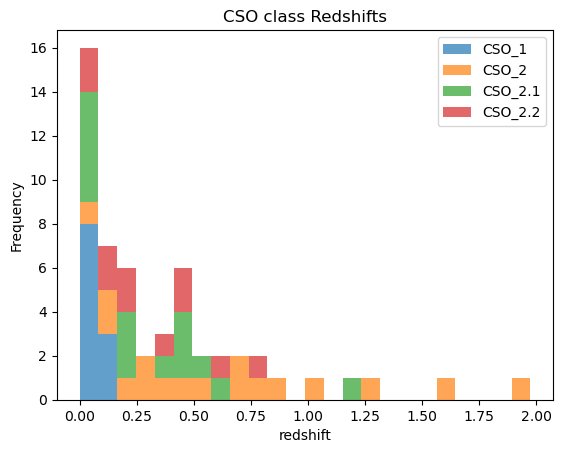

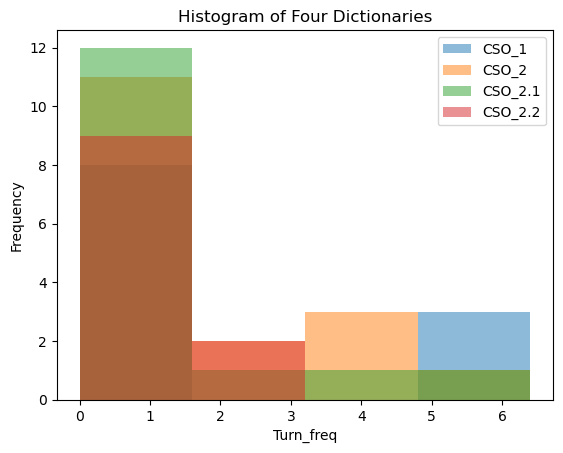

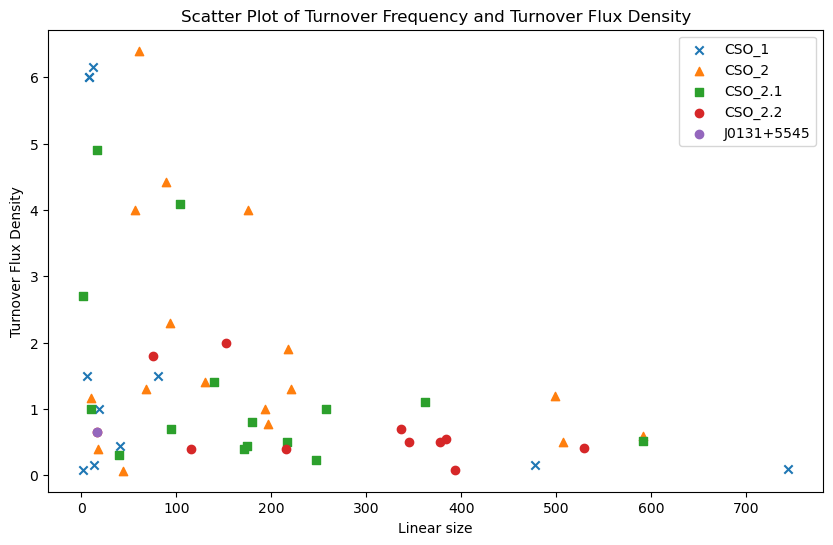

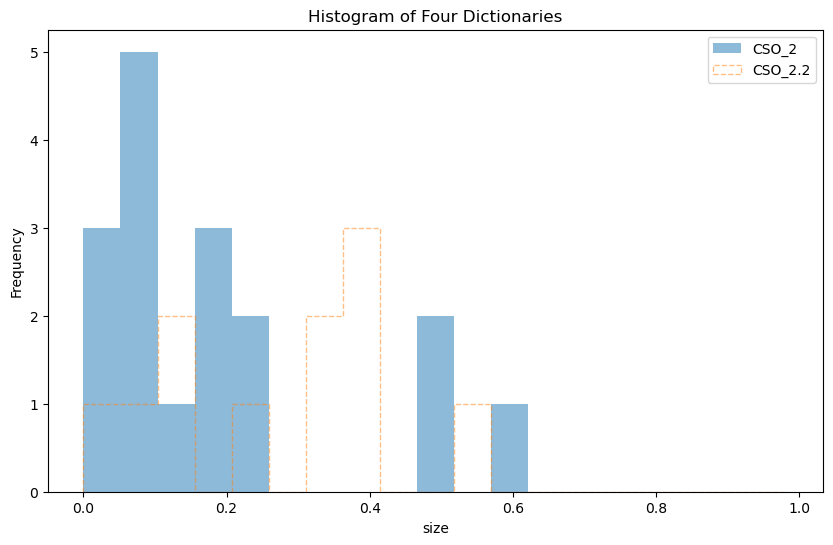

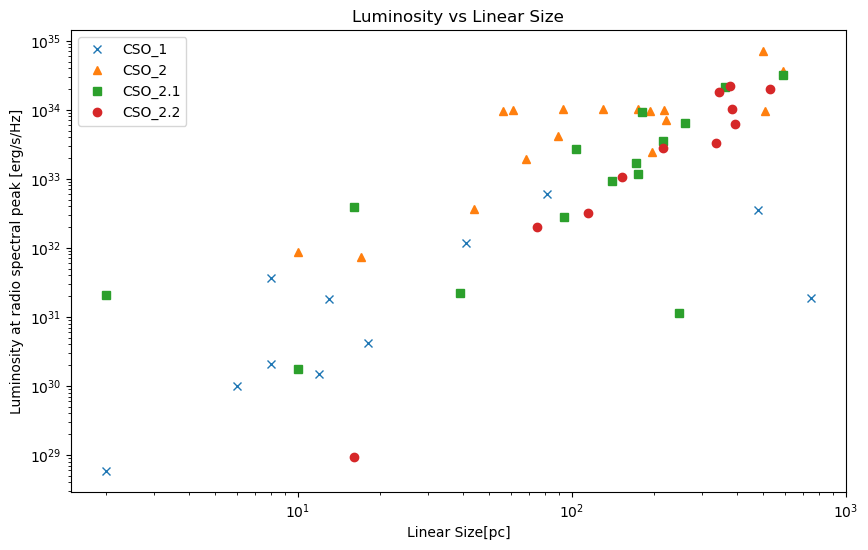

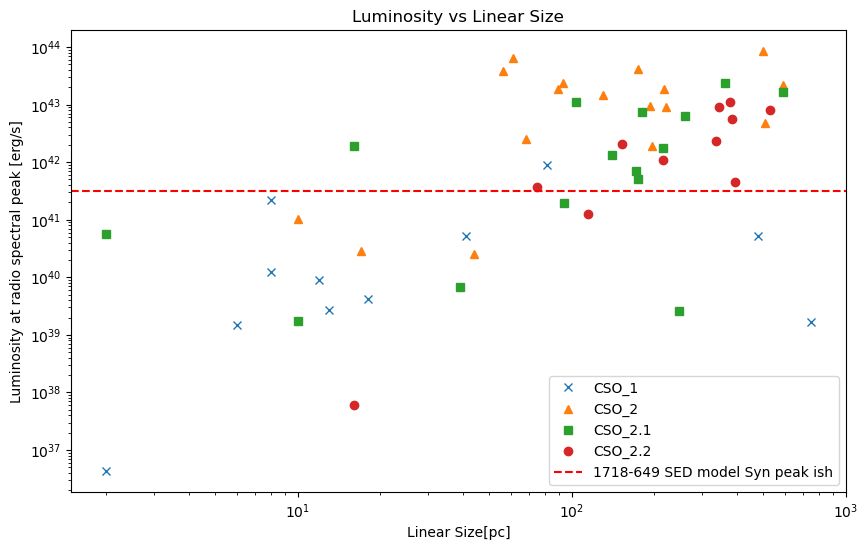

50.47209858132503 Mpc


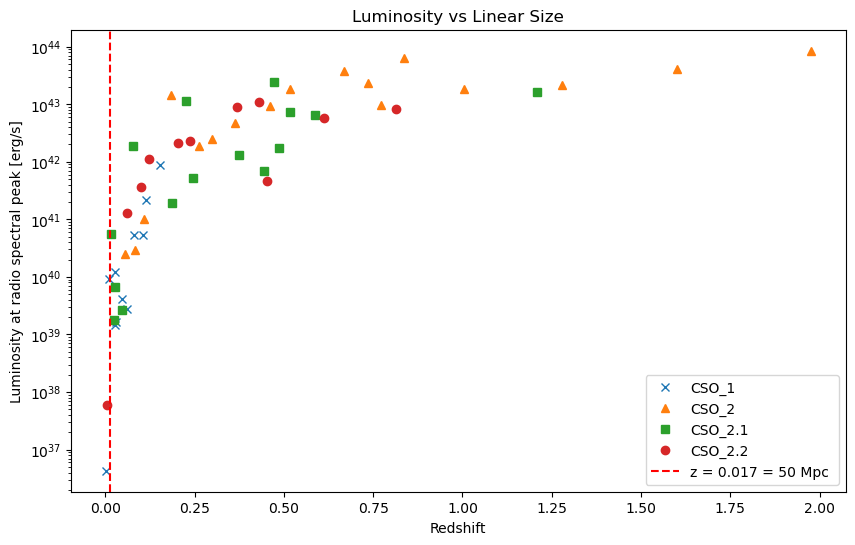

In [8]:
n_cso =(1.2*10**4*u.Gpc**-3).to(u.Mpc**-3)
print(n_cso.value*50**3*4*np.pi/3)


CSO_df = pd.DataFrame.from_dict(cso_galaxies, orient='index')

CSO_df.reset_index(inplace=True)


CSO_df.rename(columns={'index': 'Object Name'}, inplace=True)
#print(CSO_df)
print(CSO_df.columns)
selected_columns = CSO_df[['Object Name','z', 'Turnover_freq', 'Turnover_flux_den','Ang_size','lin_size','class','major_axis_comb']].copy()


CSO_1 = selected_columns[selected_columns['class'] == 1]
CSO_2 = selected_columns[selected_columns['class'] == 2.0]
CSO_21 = selected_columns[selected_columns['class'] == 2.1]
CSO_22 = selected_columns[selected_columns['class'] == 2.2]
CSO_no = selected_columns[selected_columns['class'] == 'nan']
print(CSO_no)
#print(selected_columns)
# Now, calculate the covariance matrix for the selected columns
corr_matrix = selected_columns.corr()

print(corr_matrix)


print(CSO_1)
# Combine all values into a single list

bins_z = np.linspace(0,selected_columns['z'].max(), 25)
# Plot the histogram
plt.hist([CSO_1['z'], CSO_2['z'], CSO_21['z'], CSO_22['z']], bins=bins_z, alpha=0.7, label=['CSO_1', 'CSO_2', 'CSO_2.1', 'CSO_2.2'], stacked=True)


plt.xlabel('redshift')
plt.ylabel('Frequency')
plt.title('CSO class Redshifts')
plt.legend()
plt.savefig('C:/Users/henri/OneDrive/Documents/NTNU/Semester 10/Masteroppgave/Plots/hist_z.png')

# Show the plot
plt.show()


bins_t = np.linspace(0,selected_columns['Turnover_freq'].max(), 5)
# Plot the histogram
plt.hist(CSO_1['Turnover_freq'], bins=bins_t, alpha=0.5, label='CSO_1')
plt.hist(CSO_2['Turnover_freq'], bins=bins_t, alpha=0.5, label='CSO_2')
plt.hist(CSO_21['Turnover_freq'], bins=bins_t, alpha=0.5, label='CSO_2.1')
plt.hist(CSO_22['Turnover_freq'], bins=bins_t, alpha=0.5, label='CSO_2.2')
plt.xlabel('Turn_freq')
plt.ylabel('Frequency')
plt.title('Histogram of Four Dictionaries')
plt.legend()

# Show the plot
plt.show()





plt.figure(figsize=(10, 6))
plt.scatter(CSO_1['lin_size']*1e3, CSO_1['Turnover_freq'], label='CSO_1',marker = 'x')
plt.scatter(CSO_2['lin_size']*1e3, CSO_2['Turnover_freq'], label='CSO_2',marker = '^')
plt.scatter(CSO_21['lin_size']*1e3, CSO_21['Turnover_freq'], label='CSO_2.1',marker = 's')
plt.scatter(CSO_22['lin_size']*1e3, CSO_22['Turnover_freq'], label='CSO_2.2',marker = 'o')
plt.scatter(CSO_22[CSO_22['Object Name']=='J0131+5545']['lin_size']*1e3,CSO_22[CSO_22['Object Name']=='J0131+5545']['Turnover_freq'],label = 'J0131+5545',marker = 'o')
plt.xlabel('Linear size')
plt.ylabel('Turnover Flux Density')
plt.title('Scatter Plot of Turnover Frequency and Turnover Flux Density')
plt.legend()
plt.show()





bins_size = np.linspace(0,selected_columns['lin_size'].max(), 20)
plt.figure(figsize=(10, 6))

#plt.hist(CSO_1['lin_size'], bins=bins_size, alpha=0.5, label='CSO_1')
plt.hist(CSO_2['lin_size'], bins=bins_size, alpha=0.5, label='CSO_2')
#plt.hist(CSO_21['lin_size'], bins=bins_size, alpha=0.5, label='CSO_2.1')
plt.hist(CSO_22['lin_size'], bins=bins_size, alpha=0.5, label='CSO_2.2',linestyle='dashed',histtype='step')
plt.xlabel('size')
plt.ylabel('Frequency')
plt.title('Histogram of Four Dictionaries')
plt.legend()
plt.show()



def redshift_to_distance(z):
    # Calculate comoving distance for a given redshift
    distance = cosmo.comoving_distance(z)
    
    # Convert distance to centimeters
    distance_cm = distance.to(u.cm)
    
    return distance_cm.value
convert_Jy = 1e-23

plt.figure(figsize=(10, 6))
plt.plot(CSO_1['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_1['z'])**2*CSO_1['Turnover_flux_den']*convert_Jy, 'x', label='CSO_1')
plt.plot(CSO_2['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_2['z'])**2*CSO_2['Turnover_flux_den']*convert_Jy, '^', label='CSO_2')
plt.plot(CSO_21['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_21['z'])**2*CSO_21['Turnover_flux_den']*convert_Jy, 's', label='CSO_2.1')
plt.plot(CSO_22['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_22['z'])**2*CSO_22['Turnover_flux_den']*convert_Jy, 'o', label='CSO_2.2')
plt.xlabel('Linear Size[pc]')
plt.ylabel('Luminosity at radio spectral peak [erg/s/Hz]')
plt.title('Luminosity vs Linear Size')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()



plt.figure(figsize=(10, 6))
plt.plot(CSO_1['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_1['z'])**2*CSO_1['Turnover_flux_den']*convert_Jy*CSO_1['Turnover_freq']*1e9, 'x', label='CSO_1')
plt.plot(CSO_2['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_2['z'])**2*CSO_2['Turnover_flux_den']*convert_Jy*CSO_2['Turnover_freq']*1e9, '^', label='CSO_2')
plt.plot(CSO_21['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_21['z'])**2*CSO_21['Turnover_flux_den']*convert_Jy*CSO_21['Turnover_freq']*1e9, 's', label='CSO_2.1')
plt.plot(CSO_22['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_22['z'])**2*CSO_22['Turnover_flux_den']*convert_Jy*CSO_22['Turnover_freq']*1e9, 'o', label='CSO_2.2')
#plt.plot(CSO_22[CSO_22['Object Name']=='J0131+5545']['lin_size']*1e3,4*np.pi*redshift_to_distance(CSO_22[CSO_22['Object Name']=='J0131+5545']['z'])**2*CSO_22[CSO_22['Object Name']=='J0131+5545']['Turnover_flux_den']*convert_Jy*CSO_22[CSO_22['Object Name']=='J0131+5545']['Turnover_freq']*1e9,label = 'J0131+5545',marker = 'o')
#plt.plot(2, 10**41.5, 'o', label='1718-649 SED model Syn peak ish')
plt.axhline(y= 10**41.5, color='r', linestyle='--', label='1718-649 SED model Syn peak ish')
plt.xlabel('Linear Size[pc]')
plt.ylabel('Luminosity at radio spectral peak [erg/s]')
plt.title('Luminosity vs Linear Size')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('C:/Users/henri/OneDrive/Documents/NTNU/Semester 10/Masteroppgave/Plots/Lin_size_vs_Luminosity.png')
plt.show()
mpc_des = cosmo.comoving_distance(0.0117)
print(mpc_des)
plt.figure(figsize=(10, 6))
plt.plot(CSO_1['z'], 4*np.pi*redshift_to_distance(CSO_1['z'])**2*CSO_1['Turnover_flux_den']*convert_Jy*CSO_1['Turnover_freq']*1e9, 'x', label='CSO_1')
plt.plot(CSO_2['z'], 4*np.pi*redshift_to_distance(CSO_2['z'])**2*CSO_2['Turnover_flux_den']*convert_Jy*CSO_2['Turnover_freq']*1e9, '^', label='CSO_2')
plt.plot(CSO_21['z'], 4*np.pi*redshift_to_distance(CSO_21['z'])**2*CSO_21['Turnover_flux_den']*convert_Jy*CSO_21['Turnover_freq']*1e9, 's', label='CSO_2.1')
plt.plot(CSO_22['z'], 4*np.pi*redshift_to_distance(CSO_22['z'])**2*CSO_22['Turnover_flux_den']*convert_Jy*CSO_22['Turnover_freq']*1e9, 'o', label='CSO_2.2')
#plt.plot(2, 10**41.5, 'o', label='1718-649 SED model Syn peak ish')
#plt.axhline(y= 10**41.5, color='r', linestyle='--', label='1718-649 SED model Syn peak ish')
plt.axvline(x=0.0117, color='r', linestyle='--', label='z = 0.017 = 50 Mpc ')
plt.xlabel('Redshift')
plt.ylabel('Luminosity at radio spectral peak [erg/s]')
plt.title('Luminosity vs Linear Size')
#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('C:/Users/henri/OneDrive/Documents/NTNU/Semester 10/Masteroppgave/Plots/z_vs_Luminosity.png')
plt.show()




In [130]:
cso_galaxies_SSA_5GHz ={
    "J0029+345": {"z": '0.517', 'class':'2.0','T_freq': '0.8','T_flux_den': '1.178', 'vlba_flux':'5','ang_size':'2.1','flux_density_vlba':'0.766','LS': '0.180'}, 
    "J0111+3906": { "z": '0.66847','class':'2.0', 'T_freq': '4.0', 'T_flux_den': '0.88189', 'vlba_flux':'5','ang_size':'0.95', 'flux_density_vlba':'0.862','LS': '0.56'},

    "J0119+3210": { "z": '0.0602','class':'2.2', 'T_freq': '0.4', 'T_flux_den': '0.5125', 'vlba_flux':'5','ang_size':'9.85', 'flux_density_vlba':'0.205','LS': '0.115'},
    'J0405+3803':{ "z": '0.055','class':'2.0', 'T_freq': '0.07', 'T_flux_den': '2.554', 'vlba_flux':'5','ang_size':'2.7', 'flux_density_vlba':'0.418','LS': '0.044'},

    'J0713+4349': { "z": '0.518','class':'2.0', 'T_freq': '1.9', 'T_flux_den': '0.94311', 'vlba_flux':'5','ang_size':'1.45', 'flux_density_vlba':'0.722','LS': '0.217'},

    'J1035+5628': { "z": '0.0460','class':'2.0', 'T_freq': '1.3', 'T_flux_den': '1.0659', 'vlba_flux':'5','ang_size':'1.6', 'flux_density_vlba':'0.741','LS': '0.221'},

    'J1158+2450 ': { "z": '0.203','class':'2.2', 'T_freq': '2', 'T_flux_den': '0.588', 'vlba_flux':'5','ang_size':'4', 'flux_density_vlba':'0.566','LS': '0.152'},
    'J1347+1217': { "z": '0.121','class':'2.2', 'T_freq': '0.4', 'T_flux_den': '1.3947', 'vlba_flux':'5','ang_size':'1', 'flux_density_vlba':'0.488','LS': '0.215'},









    "J1407+2827": { "z": '0.077','class':'2.1', 'T_freq': '4.9', 'T_flux_den': '2.9375', 'vlba_flux':'5','ang_size':'1.2', 'flux_density_vlba':'2.350','LS': '0.016'},
   
 
    "J2022+6136": {"z": '0.2266','class':'2.1', 'T_freq': '4.086', 'T_flux_den': '1.57256', 'vlba_flux':'5','ang_size':'2', 'flux_density_vlba':'1.787','LS': '0.104'},
    'J2355+4950 ': { "z": '0.238','class':'2.2', 'T_freq': '0.7', 'T_flux_den': '1.5450', 'vlba_flux':'5','ang_size':'1.8', 'flux_density_vlba':'0.791','LS': '0.337'},

} #Three values checked by me

In [133]:
import mpmath as mp
def calculate_B_SSA(b_alpha, S_m, d_m, nu_m, delta, z):
  
    B_SSA = 10**-5*(b_alpha) * S_m**(-2) * d_m**(4) * nu_m**(5) * (delta / (1 + z))**(-1)
    
    return B_SSA

def calc_R_size(ang_size, z):
    return ( (ang_size*u.mas).to(u.rad)/u.rad*cosmo.angular_diameter_distance(z)).to(u.pc)

CSO_SSA_5GHz_df = pd.DataFrame.from_dict(cso_galaxies_SSA_5GHz, orient='index')

CSO_SSA_5GHz_df.reset_index(inplace=True)


CSO_SSA_5GHz_df.rename(columns={'index': 'Object Name'}, inplace=True)
columns_to_convert = ['z', 'class', 'T_flux_den', 'T_freq','vlba_flux', 'ang_size','flux_density_vlba','LS']
CSO_SSA_5GHz_df[columns_to_convert] = CSO_SSA_5GHz_df[columns_to_convert].astype(float)
#print(CSO_df)


##Size of lobe

R_size_list = []
for i in range(0,len(CSO_SSA_5GHz_df['z'])):
    R_size_list.append(calc_R_size(CSO_SSA_5GHz_df['ang_size'].iloc[i]*1.8,CSO_SSA_5GHz_df['z'].iloc[i]).value)


CSO_SSA_5GHz_df['R'] = R_size_list


R_size_est = []
for i in range(0,len(CSO_SSA_5GHz_df['z'])):
    R_size_est.append(CSO_SSA_5GHz_df['LS'].iloc[i]*0.18*1e3)

CSO_SSA_5GHz_df['R_est'] = R_size_est
###SSA 
b_alpha = 1.8
b_alpha_min = 1.08
b_alpha_max = 2.36

B_SSA = []
for i in range(0,len(CSO_SSA_5GHz_df['z'])):
    if abs(CSO_SSA_5GHz_df['T_freq'].iloc[i] - 5)<10 :

        B_SSA.append(calculate_B_SSA(b_alpha, float(CSO_SSA_5GHz_df['T_flux_den'].iloc[i]), float(CSO_SSA_5GHz_df['ang_size'].iloc[i])*1.8, float(CSO_SSA_5GHz_df['T_freq'].iloc[i]), 1, float(CSO_SSA_5GHz_df['z'].iloc[i])))
    else:
        B_SSA.append(0)
CSO_SSA_5GHz_df['B_SSA'] = B_SSA

##Equipartion


def b_of_n(n):
    term1 = mp.gamma((3 * n + 1) / 6)
    term2 = mp.gamma((3 * n + 11) / 6)
    term3 = mp.gamma((n + 3) / 2)
    term4 = mp.gamma((n + 4) / 2)
    
    numerator = mp.sqrt(3 / mp.pi) * term1 * term2 * term3
    denominator = (n + 1) * term4
    
    result = (2 ** (n - 4)) * (numerator / denominator)
    
    return float(result)

print(b_of_n(0.8))
n = 0.8 
e = const.e.esu.value
m_e = const.m_e.cgs.value
c = const.c.cgs.value
m_p = const.m_p.cgs.value


def B_equipartion(G,H,R,V,S_v,nu,alpha):
    return (6*np.pi*G/H*R**2/V*S_v*nu**alpha)**(2/7)

def G_val(eta, e,m,c,v_min,v_max, n):
    return eta/(1-2*n)*(e/(m**3*c**5))**(n-1/2)*(v_max**(1/2-n)-v_min**(1/2-n))

def H_val(b_n,e,m,c,n):
    return b_n*(e**3/(m*c**2))*(3*e/(4*np.pi*m**3*c**5))**n


B_vals_equi = []

for i in range(0,len(CSO_SSA_5GHz_df['z'])):
    G = G_val(2,e,m_e,c,10**7,10**11,n)
    H = H_val(b_of_n(n),e,m_e,c,n)
    B_vals_equi.append(B_equipartion(G,H,(float(CSO_SSA_5GHz_df['R'].iloc[i])*u.pc).to(u.cm).value,(4/3*np.pi*((float(CSO_SSA_5GHz_df['R'].iloc[i])*u.pc).to(u.cm))**3).value,float(CSO_SSA_5GHz_df['T_flux_den'].iloc[i]),float(CSO_SSA_5GHz_df['T_freq'].iloc[i]),n))

CSO_SSA_5GHz_df['B_equi'] = B_vals_equi

print(CSO_SSA_5GHz_df)


0.08064639894517045
    Object Name        z  class  T_freq  T_flux_den  vlba_flux  ang_size  \
0     J0029+345  0.51700    2.0   0.800     1.17800        5.0      2.10   
1    J0111+3906  0.66847    2.0   4.000     0.88189        5.0      0.95   
2    J0119+3210  0.06020    2.2   0.400     0.51250        5.0      9.85   
3    J0405+3803  0.05500    2.0   0.070     2.55400        5.0      2.70   
4    J0713+4349  0.51800    2.0   1.900     0.94311        5.0      1.45   
5    J1035+5628  0.04600    2.0   1.300     1.06590        5.0      1.60   
6   J1158+2450   0.20300    2.2   2.000     0.58800        5.0      4.00   
7    J1347+1217  0.12100    2.2   0.400     1.39470        5.0      1.00   
8    J1407+2827  0.07700    2.1   4.900     2.93750        5.0      1.20   
9    J2022+6136  0.22660    2.1   4.086     1.57256        5.0      2.00   
10  J2355+4950   0.23800    2.2   0.700     1.54500        5.0      1.80   

    flux_density_vlba     LS          R   R_est         B_SSA    B_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1, 1, 3, 1, 1, 1, 3, 3, 2, 2, 3]


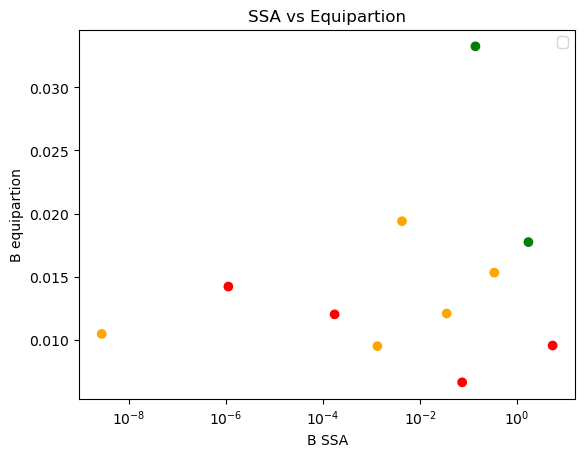

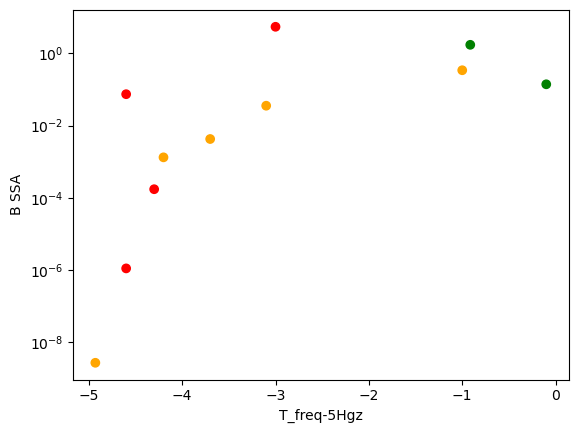

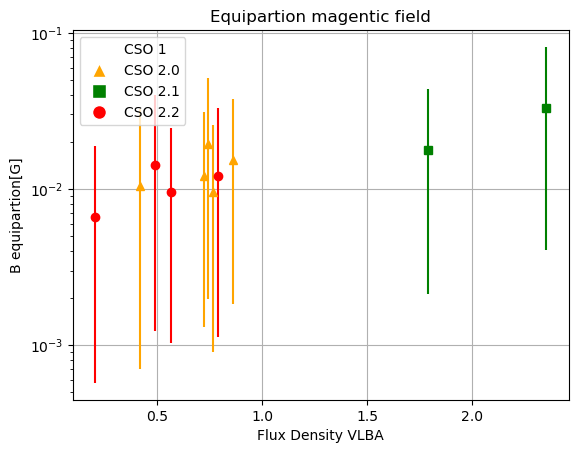

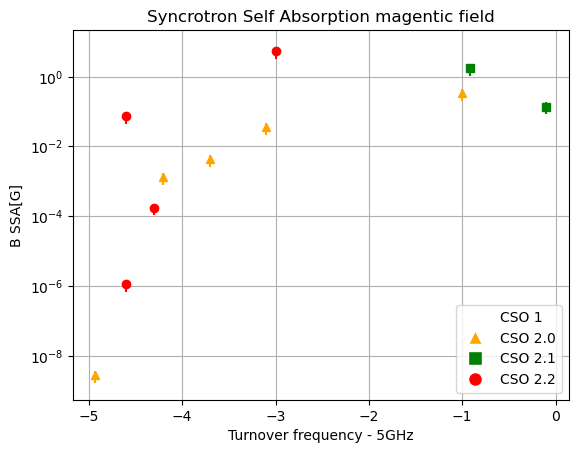

B_SSA B_SSA_R_est
0.0013163901963969924 0.004499566207459632
0.33810101102078655 1585.5244199030708
0.07352033285159924 0.07168073771429648
2.7297222267348106e-09 1.415145913597312e-08
0.03529796037080263 1.1166794458225298
0.004233094636210995 221.8899295401392
5.3859639763431915 8.62674659822801
1.1150811978660639e-06 0.01011900660525345
0.1381426753631316 0.09253788863949834
1.7079015422159938 6.831327158802019
0.00017290455049277407 0.10020170874222675


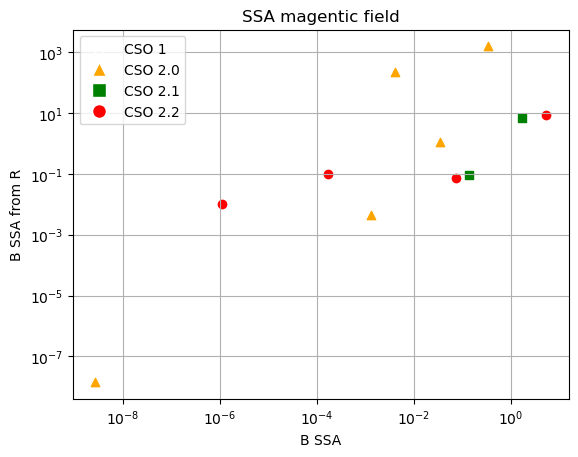

B_equiv B_equiv_R_est
0.009519173965967694 0.008719100666020762
0.015335695281457087 0.008384557580763844
0.006655791231579781 0.006667849096619006
0.010483854768346939 0.009321208598276023
0.012097672412645491 0.009452489067813307
0.019404453048663273 0.008928853947012953
0.00956759524675013 0.009251021287549404
0.014232220540181539 0.007422845530873334
0.03324011548777092 0.03420516475308744
0.01775274480004522 0.0160791279782633
0.012034121228102317 0.0076392783014816775


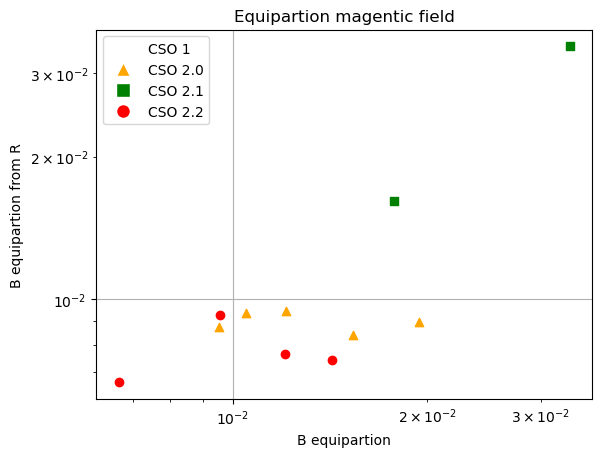

In [143]:
classes = list(CSO_SSA_5GHz_df['class'])
for i in range(len(classes)):
    if float(classes[i]) == 2.0:

        classes[i]= 1
    elif float(classes[i]) == 2.1:
        classes[i]= 2
    else:
        classes[i]= 3
print(classes)
class_colors = [ 'blue','orange', 'green', 'red']
class_marker = ['x','^','s','o']

plt.figure()
plt.scatter(CSO_SSA_5GHz_df['B_SSA'],CSO_SSA_5GHz_df['B_equi'],c=[class_colors[c] for c in classes])
plt.xlabel('B SSA')
plt.ylabel('B equipartion')
plt.title('SSA vs Equipartion')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
plt.scatter(CSO_SSA_5GHz_df['T_freq']-5,CSO_SSA_5GHz_df['B_SSA'],c=[class_colors[c] for c in classes])
plt.xlabel('T_freq-5Hgz')
plt.ylabel('B SSA')
plt.yscale('log')
#plt.xscale('log')
plt.show()


CSO_SSA_5GHz_df.corr()
legend_labels = ['CSO 1','CSO 2.0', 'CSO 2.1', 'CSO 2.2']

handles = [plt.Line2D([0], [0], marker=marker, color='w', label=label, 
                      markersize=10, markerfacecolor=color) 
           for marker,  label, color in zip(class_marker, legend_labels, class_colors)]


plt.figure()
for i in range(0,len(CSO_SSA_5GHz_df['z'])):
    n = 1.3
    G = G_val(2,e,m_e,c,10**7,10**11,n)
    H = H_val(b_of_n(n),e,m_e,c,n)
    y_max = B_equipartion(G,H,(float(CSO_SSA_5GHz_df['R'].iloc[i])*u.pc).to(u.cm).value,(4/3*np.pi*((float(CSO_SSA_5GHz_df['R'].iloc[i])*u.pc).to(u.cm))**3).value,float(CSO_SSA_5GHz_df['T_flux_den'].iloc[i]),float(CSO_SSA_5GHz_df['T_freq'].iloc[i]),n)
    n = 0.6
    G = G_val(2,e,m_e,c,10**7,10**11,n)
    H = H_val(b_of_n(n),e,m_e,c,n)
    y_min = B_equipartion(G,H,(float(CSO_SSA_5GHz_df['R'].iloc[i])*u.pc).to(u.cm).value,(4/3*np.pi*((float(CSO_SSA_5GHz_df['R'].iloc[i])*u.pc).to(u.cm))**3).value,float(CSO_SSA_5GHz_df['T_flux_den'].iloc[i]),float(CSO_SSA_5GHz_df['T_freq'].iloc[i]),n)
    y_err = [[CSO_SSA_5GHz_df['B_equi'].iloc[i]-y_min],[y_max-CSO_SSA_5GHz_df['B_equi'].iloc[i]]]
    plt.errorbar(CSO_SSA_5GHz_df['flux_density_vlba'].iloc[i],CSO_SSA_5GHz_df['B_equi'].iloc[i],yerr = y_err,c=class_colors[int(classes[i])],marker = class_marker[int(classes[i])])
plt.xlabel('Flux Density VLBA')
plt.ylabel('B equipartion[G]')
plt.title('Equipartion magentic field')
plt.yscale('log')

plt.legend(handles  = handles)
#plt.xscale('log')
plt.grid()
plt.savefig('C:/Users/henri/OneDrive/Documents/NTNU/Semester 10/Masteroppgave/Plots/Equipartion.png')
plt.show()



plt.figure()
for i in range(0,len(CSO_SSA_5GHz_df['z'])):
    y_max = calculate_B_SSA(b_alpha_max, float(CSO_SSA_5GHz_df['T_flux_den'].iloc[i]), float(CSO_SSA_5GHz_df['ang_size'].iloc[i])*1.8, float(CSO_SSA_5GHz_df['T_freq'].iloc[i]), 1, float(CSO_SSA_5GHz_df['z'].iloc[i]))
    y_min = calculate_B_SSA(b_alpha_min, float(CSO_SSA_5GHz_df['T_flux_den'].iloc[i]), float(CSO_SSA_5GHz_df['ang_size'].iloc[i])*1.8, float(CSO_SSA_5GHz_df['T_freq'].iloc[i]), 1, float(CSO_SSA_5GHz_df['z'].iloc[i]))
    y_err = [[CSO_SSA_5GHz_df['B_SSA'].iloc[i]-y_min],[y_max-CSO_SSA_5GHz_df['B_SSA'].iloc[i]]]
    plt.errorbar(CSO_SSA_5GHz_df['T_freq'].iloc[i]-5,CSO_SSA_5GHz_df['B_SSA'].iloc[i],yerr = y_err,c=class_colors[int(classes[i])],marker = class_marker[int(classes[i])])
plt.xlabel('Turnover frequency - 5GHz')
plt.ylabel('B SSA[G]')
plt.title('Syncrotron Self Absorption magentic field')
plt.yscale('log')
plt.legend(handles  = handles)
#plt.xscale('log')
plt.grid()
plt.savefig('C:/Users/henri/OneDrive/Documents/NTNU/Semester 10/Masteroppgave/Plots/SSA.png')
plt.show()


plt.figure()
print('B_SSA','B_SSA_R_est')
for i in range(0,len(CSO_SSA_5GHz_df['z'])):
    b = 1.8
    val1 = calculate_B_SSA(b, float(CSO_SSA_5GHz_df['T_flux_den'].iloc[i]), float(CSO_SSA_5GHz_df['ang_size'].iloc[i])*1.8, float(CSO_SSA_5GHz_df['T_freq'].iloc[i]), 1, float(CSO_SSA_5GHz_df['z'].iloc[i]))
    val2 = calculate_B_SSA(b, float(CSO_SSA_5GHz_df['T_flux_den'].iloc[i]), (((float(CSO_SSA_5GHz_df['R_est'].iloc[i])*u.pc).to(u.Mpc)/cosmo.angular_diameter_distance(float(CSO_SSA_5GHz_df['z'].iloc[i])))*u.rad).to(u.mas).value, float(CSO_SSA_5GHz_df['T_freq'].iloc[i]), 1, float(CSO_SSA_5GHz_df['z'].iloc[i]))
    plt.scatter(val1,val2,c=class_colors[int(classes[i])],marker = class_marker[int(classes[i])])
    print(val1,val2)
plt.xlabel('B SSA')
plt.ylabel('B SSA from R')
plt.title('SSA magentic field')
plt.yscale('log')
plt.xscale('log')
plt.legend(handles  = handles)
plt.grid()
plt.savefig('C:/Users/henri/OneDrive/Documents/NTNU/Semester 10/Masteroppgave/Plots/SSA_R.png')
plt.show()



plt.figure()
print('B_equiv','B_equiv_R_est')
for i in range(0,len(CSO_SSA_5GHz_df['z'])):
    n = 0.8
    G = G_val(2,e,m_e,c,10**7,10**11,n)
    H = H_val(b_of_n(n),e,m_e,c,n)
    val1 = B_equipartion(G,H,(float(CSO_SSA_5GHz_df['R'].iloc[i])*u.pc).to(u.cm).value,(4/3*np.pi*((float(CSO_SSA_5GHz_df['R'].iloc[i])*u.pc).to(u.cm))**3).value,float(CSO_SSA_5GHz_df['T_flux_den'].iloc[i]),float(CSO_SSA_5GHz_df['T_freq'].iloc[i]),n)
    val2 = B_equipartion(G,H,(float(CSO_SSA_5GHz_df['R_est'].iloc[i])*u.pc).to(u.cm).value,(4/3*np.pi*((float(CSO_SSA_5GHz_df['R_est'].iloc[i])*u.pc).to(u.cm))**3).value,float(CSO_SSA_5GHz_df['T_flux_den'].iloc[i]),float(CSO_SSA_5GHz_df['T_freq'].iloc[i]),n)
    plt.scatter(val1,val2,c=class_colors[int(classes[i])],marker = class_marker[int(classes[i])])
    print(val1,val2)
plt.xlabel('B equipartion')
plt.ylabel('B equipartion from R')  
plt.title('Equipartion magentic field')

plt.xscale('log')
plt.yscale('log')
plt.legend(handles = handles)
plt.grid()
plt.savefig('C:/Users/henri/OneDrive/Documents/NTNU/Semester 10/Masteroppgave/Plots/Bequiv_R.png')
plt.show()

In [18]:
import numpy as np

# Constants
E = 10 * u.EeV  # Energy in exaelectronvolts
q = 1.60218e-19 * u.C  # charge of a proton in Coulombs
m_p = const.m_p.cgs # mass of proton in grams
m_p = m_p.to(u.kg)  # mass of proton converted to kilograms
c = 3e8*(u.m / u.s)  # speed of light in m/s
B = 1 * u.nG  # Magnetic field in nanoGauss
L_c = 1 * u.Mpc  # Coherence length in Megaparsecs
D = 9*L_c 

# Relativistic momentum
p = np.sqrt((E**2) - (m_p * c**2)**2) / c

# Gyroradius
r_g = p / (q * B)

# Deflection angle
N = D / L_c
theta = np.sqrt(N) * (r_g / L_c)
#theta_degrees = np.degrees(theta)
theta = theta.decompose()*u.rad
print(theta.to(u.deg))


print((D.to(u.m)/c/np.cos(0.1)-D.to(u.m)/c).to(u.yr))


den = 1.4*1e4*u.Gpc**-3
den_mpc = den.to(u.Mpc**-3)
print(den_mpc)

1856.8258551951787 deg
147282.44872977506 yr
1.3999999999999998e-05 1 / Mpc3


[7.564441800705602e+27, 1.0102577421660014e+27, 2.8705916610171593e+27]
[1.328238721885204e+59, 1.4110322971148519e+57, 1.4614906750485463e+59]
[8.62e-24, 2.35e-23, 1.78e-23]
[0.030035077274217028, 0.04858698706282305, 0.020767888817909905]


In [20]:
##test 
S_21_7 = 0.196
S_11_2 = 0.384
S_7_7 = 0.488
S_4_8 = 0.686
S_2_3 = 1.027
S_1_3 = 1.206 

v_21_7 = 21.7
v_11_2 = 11.2
v_7_7 = 7.7
v_4_8 = 4.8
v_2_3 = 2.3
v_1_3 = 1.3

z = 0.45

print(B_equipartion(G_val(2,e,m_e,c,10**7,10**11,n),H_val(b_n,e,m_e,c,n),redshift_to_distance(z),(4/3*np.pi*(calc_R_size(1.5*1.8,z).to(u.cm)/2)**3).value,S_21_7*convert_Jy,v_21_7*1e9,n))
print(B_equipartion(G_val(2,e,m_e,c,10**7,10**11,n),H_val(b_n,e,m_e,c,n),redshift_to_distance(z),(4/3*np.pi*(calc_R_size(1.5*1.8,z).to(u.cm)/2)**3).value,S_11_2*convert_Jy,v_11_2*1e9,n))
print(B_equipartion(G_val(2,e,m_e,c,10**7,10**11,n),H_val(b_n,e,m_e,c,n),redshift_to_distance(z),(4/3*np.pi*(calc_R_size(1.5*1.8,z).to(u.cm)/2)**3).value,S_7_7*convert_Jy,v_7_7*1e9,n))
print(B_equipartion(G_val(2,e,m_e,c,10**7,10**11,n),H_val(b_n,e,m_e,c,n),redshift_to_distance(z),(4/3*np.pi*(calc_R_size(1.5*1.8,z).to(u.cm)/2)**3).value,S_4_8*convert_Jy,v_4_8*1e9,n))
print(B_equipartion(G_val(2,e,m_e,c,10**7,10**11,n),H_val(b_n,e,m_e,c,n),redshift_to_distance(z),(4/3*np.pi*(calc_R_size(1.5*1.8,z).to(u.cm)/2)**3).value,S_2_3*convert_Jy,v_2_3*1e9,n))
print(B_equipartion(G_val(2,e,m_e,c,10**7,10**11,n),H_val(b_n,e,m_e,c,n),redshift_to_distance(z),(4/3*np.pi*(calc_R_size(1.5*1.8,z).to(u.cm)/2)**3).value,S_1_3*convert_Jy,v_1_3*1e9,n))


0.02989061497689247
0.0311407914356557
0.030610782695138748
0.030284376399458145
0.028724824246030286
0.026397158104728008


0.8624816378827868 1 / cm3
93827011695635.06 eV
ion energy density:  6.046209090677495e-15 erg / cm3
magnetic field energy density:  3.978873577297384e-06 erg / cm3
ion luminosity:  2.1687766026747247e+36 erg / s
magnetic field luminosity:  1.4272228747015284e+45 erg / s
ion emissivity 8.207344673034013e+38 erg / (Mpc3 s)
ion energy density extra galactic:  9.295663391958633e-21 erg / cm3
ion luminosity extra galactic:  3.334356613949128e+30 erg / s
ion emissivity extra galactic 1.2618272421299965e+33 erg / (Mpc3 yr)


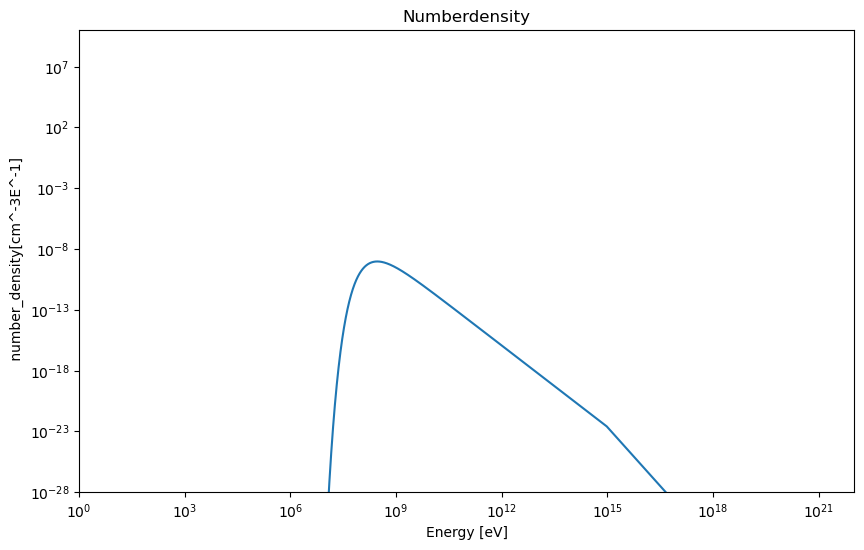

In [26]:
####mass loading
ev_to_erg = 1.60218e-12*u.erg/u.eV
m_p = const.m_p.cgs.value
m_e = const.m_e.cgs.value
m_helium = 4*const.m_p.cgs.value
m_heavier_ions = 27*const.m_p.cgs.value
percent_h = 0.74
percent_he = 0.24
percent_heavier = 0.02
mass_loading_rate = 0.2 #M_sun/yr
year_to_second = 60*60*24*365
timescale = 1000 #yr
percent_mass_loss = 0
mass_loaded= mass_loading_rate*const.M_sun.cgs.value *timescale*(1-percent_mass_loss)
number_ions = mass_loaded/(percent_h*m_p + percent_he*m_helium + percent_heavier*m_heavier_ions)
Radius_radio_lobe_cso_22 = (0.01*u.kpc).to(u.cm)
B_avg = 10**-2*u.g**(1/2)*u.cm**(-1/2)*u.s**(-1)
number_density_ions = number_ions/(4/3*np.pi*Radius_radio_lobe_cso_22**3)

c = const.c.cgs
print(number_density_ions)
E = np.logspace(1, 21, 8000)*u.eV
delta = 2.23 #proton spectral index
E_min = (1*m_p*c**2*u.g).to(u.erg)/ev_to_erg
E_br = (1e6*m_p*c**2*u.g).to(u.erg)/ev_to_erg



def n_ions(E,delta,D):
    if E < E_br:
        
        return D*E**(-delta)*2**(-E_min/E)
    else:
        return D*E_br**(1)*E**(-delta-1)*2**(-E_min/E)

D = 1 
print((1e5*m_p*c**2*u.g).to(u.erg)/ev_to_erg)
 #span of proton energy that follow the powerlaw 


vals = []
for i in range(0,len(E)):
    vals.append(n_ions(E[i],delta,D).value)
   
#vals = np.array(vals)

val  = np.trapz(vals,E)


D = number_density_ions/val
print(D,number_density_ions,np.trapz(n_ions(E,delta,D),E))
n_cso = 1.2*10**(-5)*u.Mpc**(-3)
def energy_density(E,delta,D):
    return E*ev_to_erg*n_ions(E,delta,D)

energy_density_vals = []
for i in range(0,len(E)):
    energy_density_vals.append(energy_density(E[i],delta,D).value) 
u_p = np.trapz(energy_density_vals,E*ev_to_erg)#.to(u.erg/u.cm**3)
u_p = (u_p/(1*u.cm**3))#.to(u.erg/u.cm**3)
print('ion energy density: ', u_p)
u_b = (B_avg**2/(8*np.pi)).to(u.erg/u.cm**3)#.decompose(bases= u.cgs.bases)

print('magnetic field energy density: ', u_b)

print('ion luminosity: ',u_p*Radius_radio_lobe_cso_22**2*4*np.pi*c) #UHECRs luminosity
print('magnetic field luminosity: ', u_b*Radius_radio_lobe_cso_22**2*4*np.pi*c) #magnetic field luminosity

print('ion emissivity', u_p*Radius_radio_lobe_cso_22**2*4*np.pi*c*n_cso*year_to_second)


E_extra_gal  = np.logspace(18, 21, 30000)*u.eV

energy_density_vals_extra_gal = []
for i in range(0,len(E_extra_gal)):
    energy_density_vals_extra_gal.append(energy_density(E_extra_gal[i],delta,D).value)

u_p_extra_gal = (np.trapz(energy_density_vals_extra_gal,E_extra_gal)*(1/u.cm**3)).to(u.erg/u.cm**3)
print('ion energy density extra galactic: ', u_p_extra_gal)
print('ion luminosity extra galactic: ',u_p_extra_gal*Radius_radio_lobe_cso_22**2*4*np.pi*c) #UHECRs luminosity
print('ion emissivity extra galactic', u_p_extra_gal*Radius_radio_lobe_cso_22**2*4*np.pi*c*n_cso*year_to_second*u.s/u.yr)

plt.figure(figsize=(10, 6))
val_plot = []
for i in range(0,len(E)):
    val_plot.append(n_ions(E[i],delta,D).value)

plt.plot(E,val_plot)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-28,10**10)
plt.xlabel('Energy [eV]')
plt.ylabel(' number_density[cm^-3E^-1]')
plt.title('Numberdensity')
plt.show()


In [126]:
####mass loading
ev_to_erg = 1.60218e-12#*u.erg/u.eV
m_p = const.m_p.cgs.value
m_e = const.m_e.cgs.value
m_helium = 4*const.m_p.cgs.value
m_heavier_ions = 27*const.m_p.cgs.value
percent_h = 0.74
percent_he = 0.24
percent_heavier = 0.02
mass_loading_rate = 0.2 #M_sun/yr
year_to_second = 60*60*24*365
timescale = 3000 #yr
percent_mass_loss = 0
mass_loaded= mass_loading_rate*const.M_sun.cgs.value *timescale*(1-percent_mass_loss)
number_ions = mass_loaded/(percent_h*m_p + percent_he*m_helium + percent_heavier*m_heavier_ions)
Radius_radio_lobe_cso_22 = ((0.01*u.kpc).to(u.cm)).value
B_avg = 10**-2*u.g**(1/2)*u.cm**(-1/2)*u.s**(-1)
number_density_ions = (number_ions/(4/3*np.pi*Radius_radio_lobe_cso_22**3))#.value

c = const.c.cgs.value
u_B = (B_avg**2/(8*np.pi)).value
gamma_vals = np.logspace(1, 13, 800)
delta = 2.27
def calc_all(gamma_vals, number_density_ions, gamma_br,Z):
    D= 1
    def n_ions(gamma,delta,D,gamma_br):
        if gamma < gamma_br:
            
            return D*gamma**(-delta)
        else:
            return D*gamma_br**(1)*gamma**(-delta-1)

    gamma_br = 1e6  
    vals = []
    for i in range(0,len(gamma_vals)):
        vals.append(n_ions(gamma_vals[i],delta,D,gamma_br))
    
    #vals = np.array(vals)

    val  = np.trapz(vals,gamma_vals)

    n_cso = 1.2*10**(-5)#*u.Mpc**(-3)
    D = number_density_ions/val



    vals = []
    for i in range(0,len(gamma_vals)):
        vals.append(n_ions(gamma_vals[i],delta,D,gamma_br)*gamma_vals[i]*m_p*c**2*2*Z)
    vals = np.array(vals)
    val  = np.trapz(vals,gamma_vals)
    t_life = 1e3*year_to_second
    u_p = val
    ion_luminoisty = u_p*Radius_radio_lobe_cso_22**3*4*np.pi/t_life/3
    ion_emissivity = u_p*Radius_radio_lobe_cso_22**3*4*np.pi/t_life/3*n_cso*year_to_second

    gamma_extra_gal  = np.logspace(18, np.log10(gamma_vals[-1]), 3000)
    
    vals = []
    for i in range(0,len(gamma_extra_gal)):
        vals.append(n_ions(gamma_extra_gal[i],delta,D,gamma_br)*gamma_extra_gal[i]*m_p*c**2*2*Z)
    vals = np.array(vals)
    val  = np.trapz(vals,gamma_extra_gal)

    u_p_extra_gal = val
    ion_luminoisty_extra_gal = u_p_extra_gal*Radius_radio_lobe_cso_22**3*4*np.pi/t_life/3
    ion_emissivity_extra_gal = u_p_extra_gal*Radius_radio_lobe_cso_22**3*4*np.pi/t_life/3*n_cso*year_to_second

    return u_p/t_life*1e8, ion_luminoisty, ion_emissivity, u_p_extra_gal/t_life, ion_luminoisty_extra_gal, ion_emissivity_extra_gal




Number_density_protons = number_density_ions*percent_h
Number_density_he = number_density_ions*percent_he
Number_density_heavier = number_density_ions*percent_heavier


max_val_protons = float(10*10**24)
gamma_max_protons = max_val_protons
gamma_vals_protons = np.logspace(1, np.log10(gamma_max_protons), 8000)
gamma_max_he = float(max_val_protons*4)
gamma_vals_he = np.logspace(1, np.log10(gamma_max_he), 8000)
gamma_max_heavier = float(max_val_protons*27)
gamma_vals_heavier = np.logspace(1, np.log10(gamma_max_heavier), 8000)

gamma_br = 1e6

def print_all(u_p, ion_luminoisty, ion_emissivity, u_p_extra_gal, ion_luminoisty_extra_gal, ion_emissivity_extra_gal,species):
    print(f'{species} energy density: ', u_p)
    print(f'{species} luminosity: ',ion_luminoisty) #UHECRs luminosity
    print(f'{species} emissivity', ion_emissivity)
    print(f'{species} energy density extra galactic: ', u_p_extra_gal)
    print(f'{species} luminosity extra galactic: ',ion_luminoisty_extra_gal) #UHECRs luminosity
    print(f'{species} emissivity extra galactic', ion_emissivity_extra_gal)
    print('\n')



u_p_protons, ion_luminoisty_protons, ion_emissivity_protons, u_p_protons_extra_gal, ion_luminoisty_protons_extra_gal, ion_emissivity_protons_extra_gal = calc_all(gamma_vals_protons, Number_density_protons, gamma_br,1)

u_p_he, ion_luminoisty_he, ion_emissivity_he, u_p_he_extra_gal, ion_luminoisty_he_extra_gal, ion_emissivity_he_extra_gal = calc_all(gamma_vals_he, Number_density_he, gamma_br,4)

u_p_heavier, ion_luminoisty_heavier, ion_emissivity_heavier, u_p_heavier_extra_gal, ion_luminoisty_heavier_extra_gal, ion_emissivity_heavier_extra_gal = calc_all(gamma_vals_heavier, Number_density_heavier, gamma_br,27)

print_all(u_p_protons, ion_luminoisty_protons, ion_emissivity_protons, u_p_protons_extra_gal, ion_luminoisty_protons_extra_gal, ion_emissivity_protons_extra_gal,'Protons')
print_all(u_p_he, ion_luminoisty_he, ion_emissivity_he, u_p_he_extra_gal, ion_luminoisty_he_extra_gal, ion_emissivity_he_extra_gal,'Helium')
print_all(u_p_heavier, ion_luminoisty_heavier, ion_emissivity_heavier, u_p_heavier_extra_gal, ion_luminoisty_heavier_extra_gal, ion_emissivity_heavier_extra_gal,'Heavier ions')


u_p_protons, ion_luminoisty_protons, ion_emissivity_protons, u_p_protons_extra_gal, ion_luminoisty_protons_extra_gal, ion_emissivity_protons_extra_gal = calc_all(gamma_vals_protons, Number_density_protons*u_B/u_p_protons, gamma_br,1)
print_all(u_p_protons, ion_luminoisty_protons, ion_emissivity_protons, u_p_protons_extra_gal, ion_luminoisty_protons_extra_gal, ion_emissivity_protons_extra_gal,'Protons')




Protons energy density:  0.0008284142943111594
Protons luminosity:  1.019501405919063e+48
Protons emissivity 3.8581195604476285e+50
Protons energy density extra galactic:  4.692026264052176e-29
Protons luminosity extra galactic:  5.774317760641668e+30
Protons emissivity extra galactic 2.185186618795148e+33


Helium energy density:  0.001074698654776826
Helium luminosity:  1.3225952244044233e+48
Helium emissivity 5.005123559618147e+50
Helium energy density extra galactic:  6.086963381159554e-29
Helium luminosity extra galactic:  7.491019611183961e+30
Helium emissivity extra galactic 2.834841533499569e+33


Heavier ions energy density:  0.0006045172110198495
Heavier ions luminosity:  7.439588509870855e+47
Heavier ions emissivity 2.815378358967447e+50
Heavier ions energy density extra galactic:  3.4239262215019787e-29
Heavier ions luminosity extra galactic:  4.2137100006066256e+30
Heavier ions emissivity extra galactic 1.5946027029495665e+33


Protons energy density:  3.978873577297384e-0

In [129]:
###Jet power

def minimum_jet_power(B,R,beta):
    return 2*np.pi*B**2/np.pi/8*R**2*c*u.cm/u.s*beta


print(minimum_jet_power(10**-2*u.g**(1/2)*u.cm**(-1/2)*u.s**(-1),Radius_radio_lobe_cso_22*u.cm,0.1))

7.136114373507641e+43 cm2 g / s3
